# Schedule Top Consumer Profiling

This notebook deals with outlier detection, particularly from the SQL domain. This work attributes itself to detection of high consumers within a database system, particularly flagging those SQL which stand out in terms of computation time/resources required to execute.

Due to the high dimensionality of the available data points, unsupervised machine learning techniques will be applied to this problem, so as to isolate data anamolies and flag them as potential bottlenecks.

### Module Installation and Importing Libraries

In [323]:
# scipy
import scipy as sc
print('scipy: %s' % sc.__version__)
# numpy
import numpy as np
print('numpy: %s' % np.__version__)
# matplotlib
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
# pandas
import pandas as pd
print('pandas: %s' % pd.__version__)
# scikit-learn
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from sklearn.ensemble import IsolationForest

scipy: 0.19.1
numpy: 1.15.2
pandas: 0.23.4


In [324]:
#
# Experiment Config
tpcds='TPCDS1' # Schema upon which to operate test
y_label = ['CPU_TIME_DELTA','OPTIMIZER_COST','EXECUTIONS_DELTA','ELAPSED_TIME_DELTA']
y_label2 = ['COST','CARDINALITY','BYTES','IO_COST','TEMP_SPACE','TIME']

### Read data from file into pandas dataframes

In [325]:
#
# Open Data
rep_hist_snapshot_path = 'C:/Users/gabriel.sammut/University/Data_ICS5200/Schedule/' + tpcds + '/rep_hist_snapshot.csv'
rep_vsql_plan_path = 'C:/Users/gabriel.sammut/University/Data_ICS5200/Schedule/' + tpcds + '/rep_vsql_plan.csv'
#
rep_hist_snapshot_df = pd.read_csv(rep_hist_snapshot_path)
rep_vsql_plan_df = pd.read_csv(rep_vsql_plan_path)
#
def prettify_header(headers):
    """
    Cleans header list from unwated character strings
    """
    header_list = []
    [header_list.append(header.replace("(","").replace(")","").replace("'","").replace(",","")) for header in headers]
    return header_list
#
rep_hist_snapshot_df.columns = prettify_header(rep_hist_snapshot_df.columns.values)
rep_vsql_plan_df.columns = prettify_header(rep_vsql_plan_df.columns.values)
print(rep_hist_snapshot_df.columns)
print('------------------------------------------')
print(rep_vsql_plan_df.columns)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Index(['SNAP_ID', 'DBID', 'INSTANCE_NUMBER', 'SQL_ID', 'PLAN_HASH_VALUE',
       'OPTIMIZER_COST', 'OPTIMIZER_MODE', 'OPTIMIZER_ENV_HASH_VALUE',
       'SHARABLE_MEM', 'LOADED_VERSIONS', 'VERSION_COUNT', 'MODULE', 'ACTION',
       'SQL_PROFILE', 'FORCE_MATCHING_SIGNATURE', 'PARSING_SCHEMA_ID',
       'PARSING_SCHEMA_NAME', 'PARSING_USER_ID', 'FETCHES_TOTAL',
       'FETCHES_DELTA', 'END_OF_FETCH_COUNT_TOTAL', 'END_OF_FETCH_COUNT_DELTA',
       'SORTS_TOTAL', 'SORTS_DELTA', 'EXECUTIONS_TOTAL', 'EXECUTIONS_DELTA',
       'PX_SERVERS_EXECS_TOTAL', 'PX_SERVERS_EXECS_DELTA', 'LOADS_TOTAL',
       'LOADS_DELTA', 'INVALIDATIONS_TOTAL', 'INVALIDATIONS_DELTA',
       'PARSE_CALLS_TOTAL', 'PARSE_CALLS_DELTA', 'DISK_READS_TOTAL',
       'DISK_READS_DELTA', 'BUFFER_GETS_TOTAL', 'BUFFER_GETS_DELTA',
       'ROWS_PROCESSED_TOTAL', 'ROWS_PROCESSED_DELTA', 'CPU_TIME_TOTAL',
       'CPU_TIME_DELTA', 'ELAPSED_TIME_TOTAL', 'ELAPSED_TIME_DELTA',
       'IOWAIT_TOTAL', 'IOWAIT_DELTA', 'CLWAIT_TOTAL', 'CLWA

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (6,20,21,22,25,26) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Pivoting tables and changing matrix shapes

Changes all dataframe shapes to be similar to each other, where in a number of snap_id timestamps are cojoined with instance metrics.

In [326]:
print('Header Lengths [Before Pivot]')
print('REP_HIST_SNAPSHOT: ' + str(len(rep_hist_snapshot_df.columns)))
print('REP_VSQL_PLAN: ' + str(len(rep_vsql_plan_df.columns)))
#
# Group By Values by SNAP_ID, PLAN_HASH_VALUE , sum all metrics (for table REP_HIST_SNAPSHOT)
rep_hist_snapshot_df = rep_hist_snapshot_df.groupby(['SNAP_ID','PLAN_HASH_VALUE','DBID','INSTANCE_NUMBER']).sum()
rep_hist_snapshot_df.reset_index(inplace=True)
#
# Group By Values by PLAN_HASH_VALUE,TIMESTAMP, sum all metrics (for table REP_VSQL_PLAN)
rep_vsql_plan_df = rep_vsql_plan_df.groupby(['TIMESTAMP','SQL_ID','ID','DBID','CON_DBID']).sum()
rep_vsql_plan_df.reset_index(inplace=True)
#
print('\nHeader Lengths [After Pivot]')
print('REP_HIST_SNAPSHOT: ' + str(len(rep_hist_snapshot_df.columns)))
print('REP_VSQL_PLAN: ' + str(len(rep_vsql_plan_df.columns)) + "\n")
print(rep_hist_snapshot_df.columns)
print(rep_vsql_plan_df.columns)

Header Lengths [Before Pivot]
REP_HIST_SNAPSHOT: 90
REP_VSQL_PLAN: 39

Header Lengths [After Pivot]
REP_HIST_SNAPSHOT: 77
REP_VSQL_PLAN: 24

Index(['SNAP_ID', 'PLAN_HASH_VALUE', 'DBID', 'INSTANCE_NUMBER',
       'OPTIMIZER_COST', 'OPTIMIZER_ENV_HASH_VALUE', 'SHARABLE_MEM',
       'LOADED_VERSIONS', 'VERSION_COUNT', 'SQL_PROFILE', 'PARSING_SCHEMA_ID',
       'PARSING_USER_ID', 'FETCHES_TOTAL', 'FETCHES_DELTA',
       'END_OF_FETCH_COUNT_TOTAL', 'END_OF_FETCH_COUNT_DELTA', 'SORTS_TOTAL',
       'SORTS_DELTA', 'EXECUTIONS_TOTAL', 'EXECUTIONS_DELTA',
       'PX_SERVERS_EXECS_TOTAL', 'PX_SERVERS_EXECS_DELTA', 'LOADS_TOTAL',
       'LOADS_DELTA', 'INVALIDATIONS_TOTAL', 'INVALIDATIONS_DELTA',
       'PARSE_CALLS_TOTAL', 'PARSE_CALLS_DELTA', 'DISK_READS_TOTAL',
       'DISK_READS_DELTA', 'BUFFER_GETS_TOTAL', 'BUFFER_GETS_DELTA',
       'ROWS_PROCESSED_TOTAL', 'ROWS_PROCESSED_DELTA', 'CPU_TIME_TOTAL',
       'CPU_TIME_DELTA', 'ELAPSED_TIME_TOTAL', 'ELAPSED_TIME_DELTA',
       'IOWAIT_TOTAL', 'I

### Dealing with empty values

In [327]:
def get_na_columns(df, headers):
    """
    Return columns which consist of NAN values
    """
    na_list = []
    for head in headers:
        if df[head].isnull().values.any():
            na_list.append(head)
    return na_list
#
print('N/A Columns\n')
print('\n REP_HIST_SNAPSHOT Features ' + str(len(rep_hist_snapshot_df.columns)) + ': ' + str(get_na_columns(df=rep_hist_snapshot_df,headers=rep_hist_snapshot_df.columns)) + "\n")
print('REP_VSQL_PLAN Features ' + str(len(rep_vsql_plan_df.columns)) + ': ' + str(get_na_columns(df=rep_vsql_plan_df,headers=rep_vsql_plan_df.columns)) + "\n")
#
def fill_na(df):
    """
    Replaces NA columns with 0s
    """
    return df.fillna(0)
#
# Populating NaN values with amount '0'
rep_hist_snapshot_df = fill_na(df=rep_hist_snapshot_df)
rep_vsql_plan_df = fill_na(df=rep_vsql_plan_df)

N/A Columns


 REP_HIST_SNAPSHOT Features 77: []

REP_VSQL_PLAN Features 24: []



### Data Ordering

Sorting of datasets in order of:

* REP_HIST_SNAPSHOT - SNAP_ID
* REP_VSQL_PLAN - TIMESTAMP, SQL_ID, ID

In [328]:
rep_hist_snapshot_df.sort_values(by=['SNAP_ID'], ascending=True, inplace=True)
rep_vsql_plan_df.sort_values(by=['TIMESTAMP','SQL_ID','ID'], ascending=True, inplace=True)

In [329]:
# def encode(df, features):
#     encoder_dict={} # Used to keep track of respective encoders, in case it is required to decoded labels further down the line
#     for f in features:
#         for col in df.columns:
#             col = str(col)
#             if col.lower() == f.lower()
#                 le = preprocessing.LabelEncoder()
#                 df[col].values = le.fit_transform(df[col].values)
#                 encoder_dict[col] = le
#     return df, le
# #
# encoded_labels_hist_snapshot = []
# encoded_labels_vsql_plan = ['OPERATION',
#                             'OPTIONS']

### Floating point precision conversion

Each column is converted into a column of type values which are floating point for higher precision, and rounded to 3 decimal places.

In [330]:
for col in rep_hist_snapshot_df.columns:
    try:
        rep_hist_snapshot_df[col].astype('float32',inplace=True)
    except:
        rep_hist_snapshot_df.drop(columns=col, inplace=True)
        print('Dropped column [' + col + ']')
#
print('-------------------------------------------------------------')
#
for col in rep_vsql_plan_df.columns:
    try:
        rep_vsql_plan_df[col].astype('float32',inplace=True)
    except:
        rep_vsql_plan_df.drop(columns=col, inplace=True)
        print('Dropped column [' + col + ']')
#
rep_hist_snapshot_df = np.round(rep_hist_snapshot_df, 3) # rounds to 3 dp
rep_vsql_plan_df = np.round(rep_vsql_plan_df, 3) # rounds to 3 dp

-------------------------------------------------------------
Dropped column [TIMESTAMP]
Dropped column [SQL_ID]


### Feature Selection

In this step, redundant features are dropped. Features are considered redundant if exhibit a standard devaition of 0 (meaning no change in value).

In [331]:
print('Before')
print(rep_hist_snapshot_df.shape)
print(rep_vsql_plan_df.shape)
#
def drop_flatline_columns(df):
    columns = df.columns
    flatline_features = []
    for i in range(len(columns)):
        try:
            std = df[columns[i]].std()
            if std == 0:
                flatline_features.append(columns[i])
        except:
            pass
    #
    #print('Features which are considered flatline:\n')
    #for col in flatline_features:
    #    print(col)
    print('\nShape before changes: [' + str(df.shape) + ']')
    df = df.drop(columns=flatline_features)
    print('Shape after changes: [' + str(df.shape) + ']')
    print('Dropped a total [' + str(len(flatline_features)) + ']')
    return df
#
rep_hist_snapshot_df = drop_flatline_columns(df=rep_hist_snapshot_df)
rep_vsql_plan_df = drop_flatline_columns(df=rep_vsql_plan_df)
#
dropped_columns_rep_hist_snapshot = ['SNAP_ID',
                                       'PLAN_HASH_VALUE',
                                       'OPTIMIZER_ENV_HASH_VALUE',
                                       'LOADED_VERSIONS',
                                       'VERSION_COUNT',
                                       'PARSING_SCHEMA_ID',
                                       'PARSING_USER_ID']
dropped_columns_rep_vsql_plan = ['PLAN_HASH_VALUE',
                                 'ID',
                                 'OBJECT#',
                                 'PARENT_ID',
                                 'SEARCH_COLUMNS']
rep_hist_snapshot_df.drop(columns=dropped_columns_rep_hist_snapshot, inplace=True)
rep_vsql_plan_df.drop(columns=dropped_columns_rep_vsql_plan, inplace=True)
#
print('After')
print(rep_hist_snapshot_df.shape)
print(rep_vsql_plan_df.shape)

Before
(1328642, 77)
(31160, 22)

Shape before changes: [(1328642, 77)]
Shape after changes: [(1328642, 62)]
Dropped a total [15]

Shape before changes: [(31160, 22)]
Shape after changes: [(31160, 14)]
Dropped a total [8]
After
(1328642, 55)
(31160, 9)


### Guaging Outliers (REP_HIST_SNAPSHOT)

Uses the following labels and plots them, so as to showcase the presence of outliers:
* CPU_TIME_DELTA
* OPTIMIZER_COST
* EXECUTIONS_DELTA
* ELAPSED_TIME_DELTA

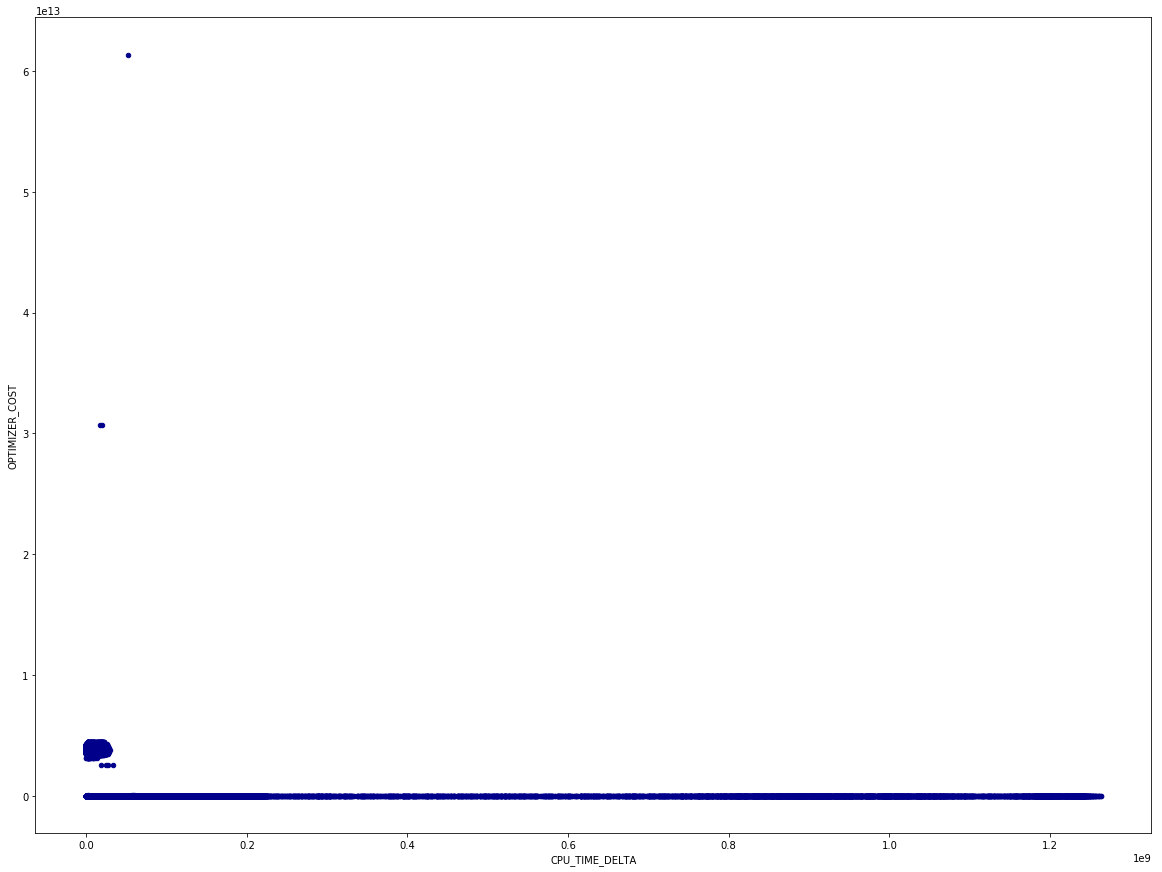

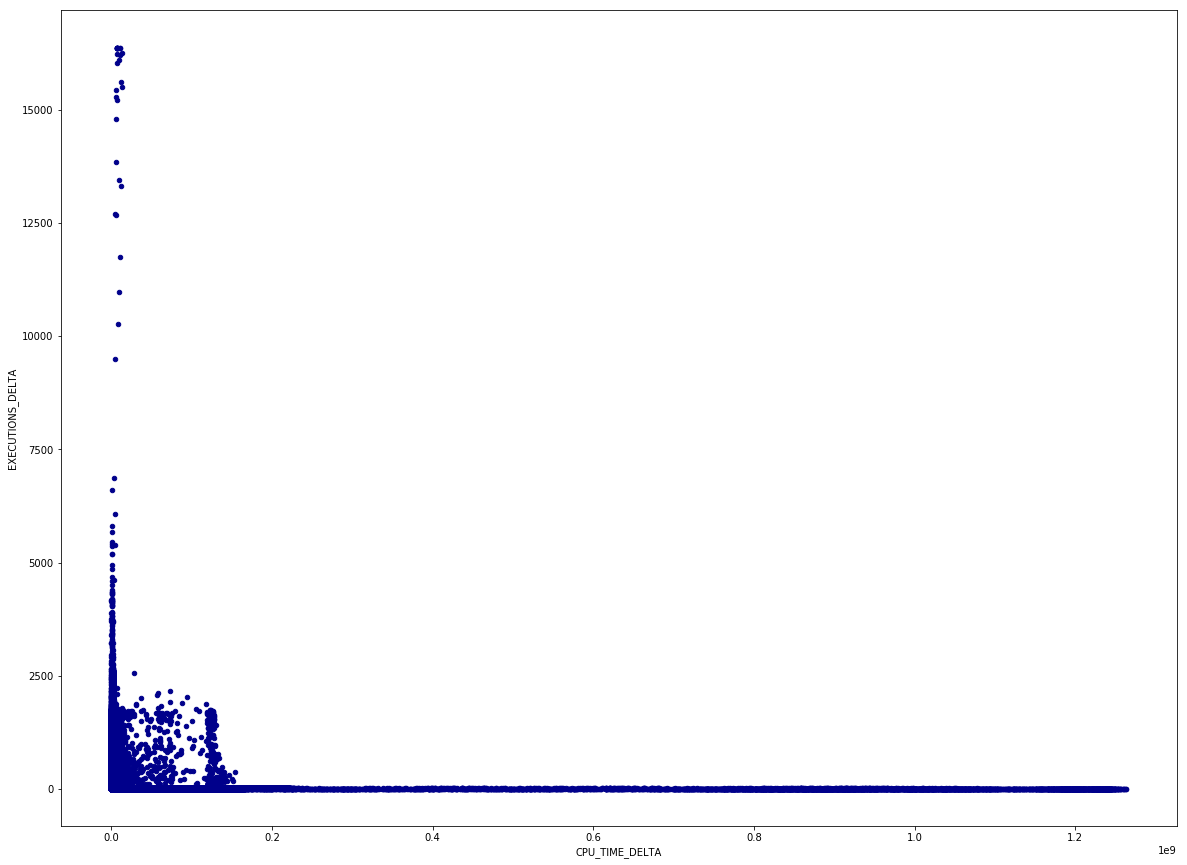

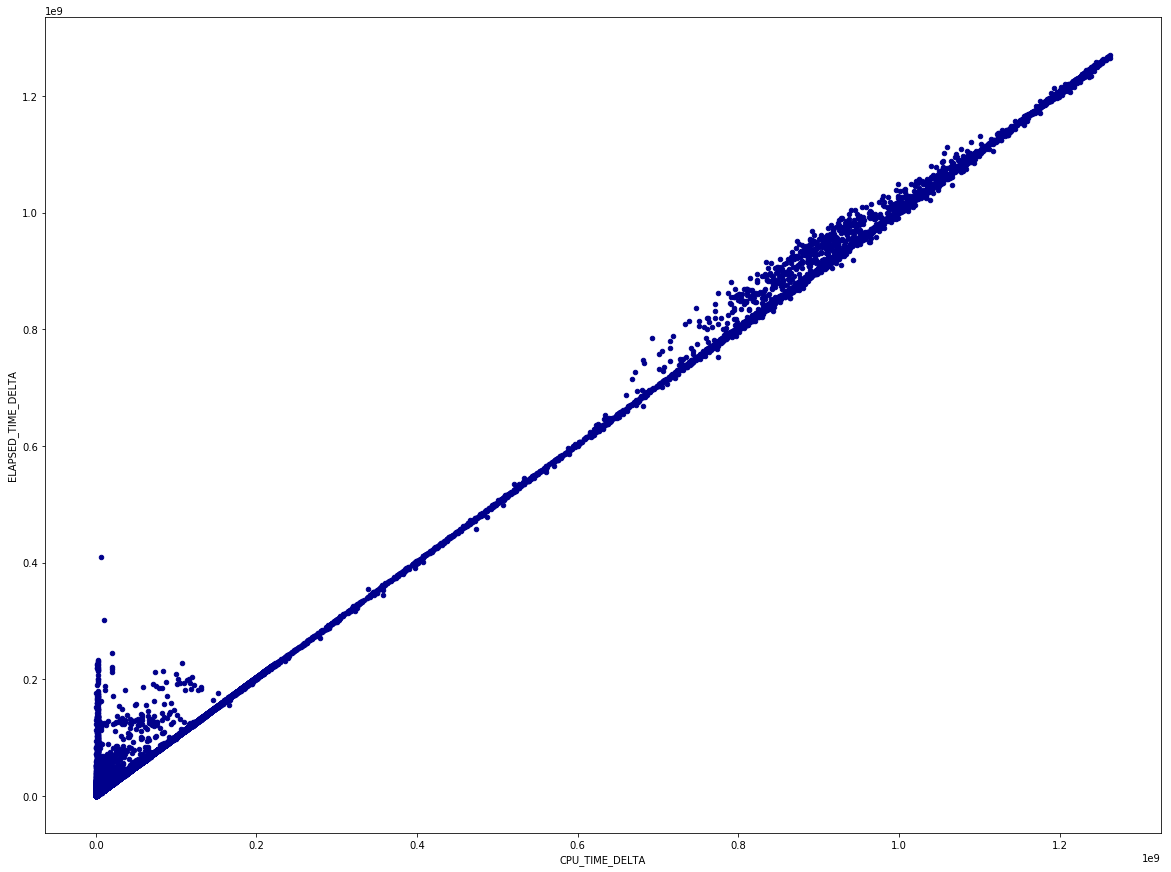

--------------------------------------------------------


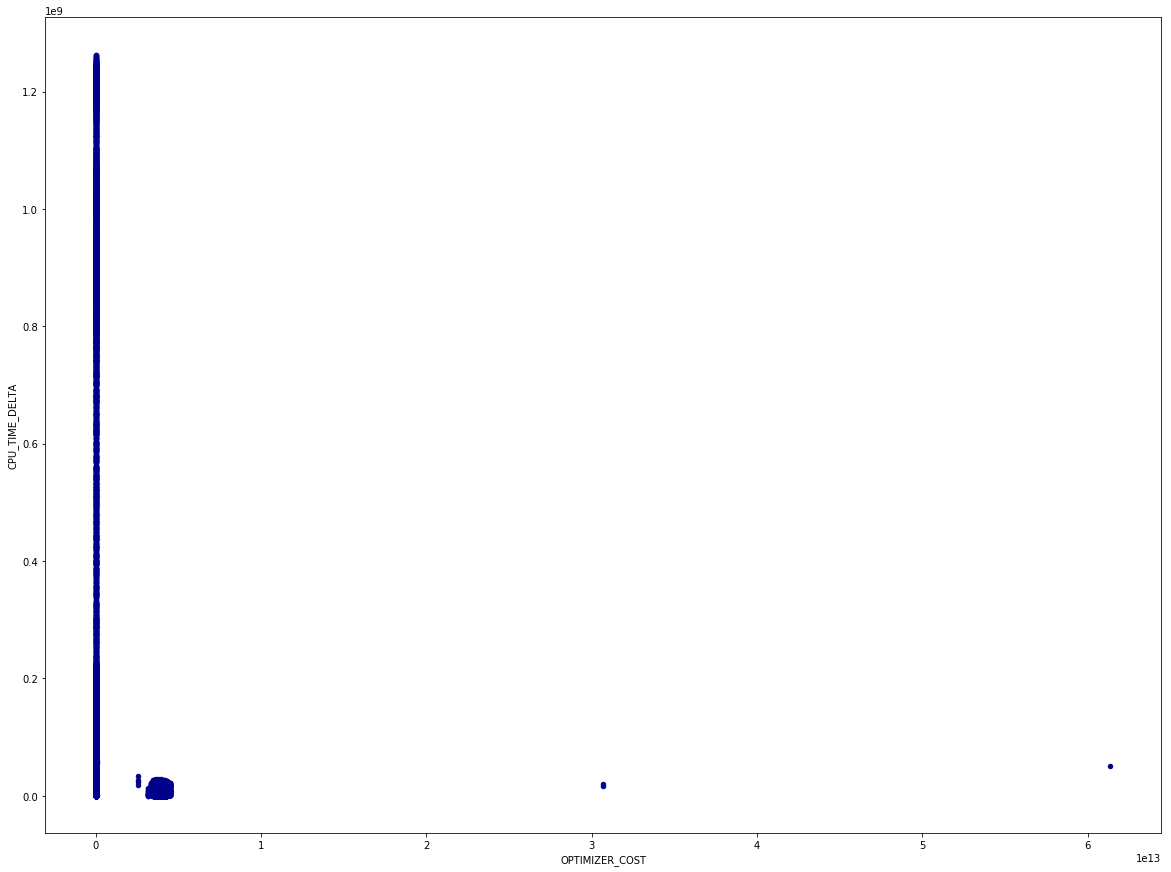

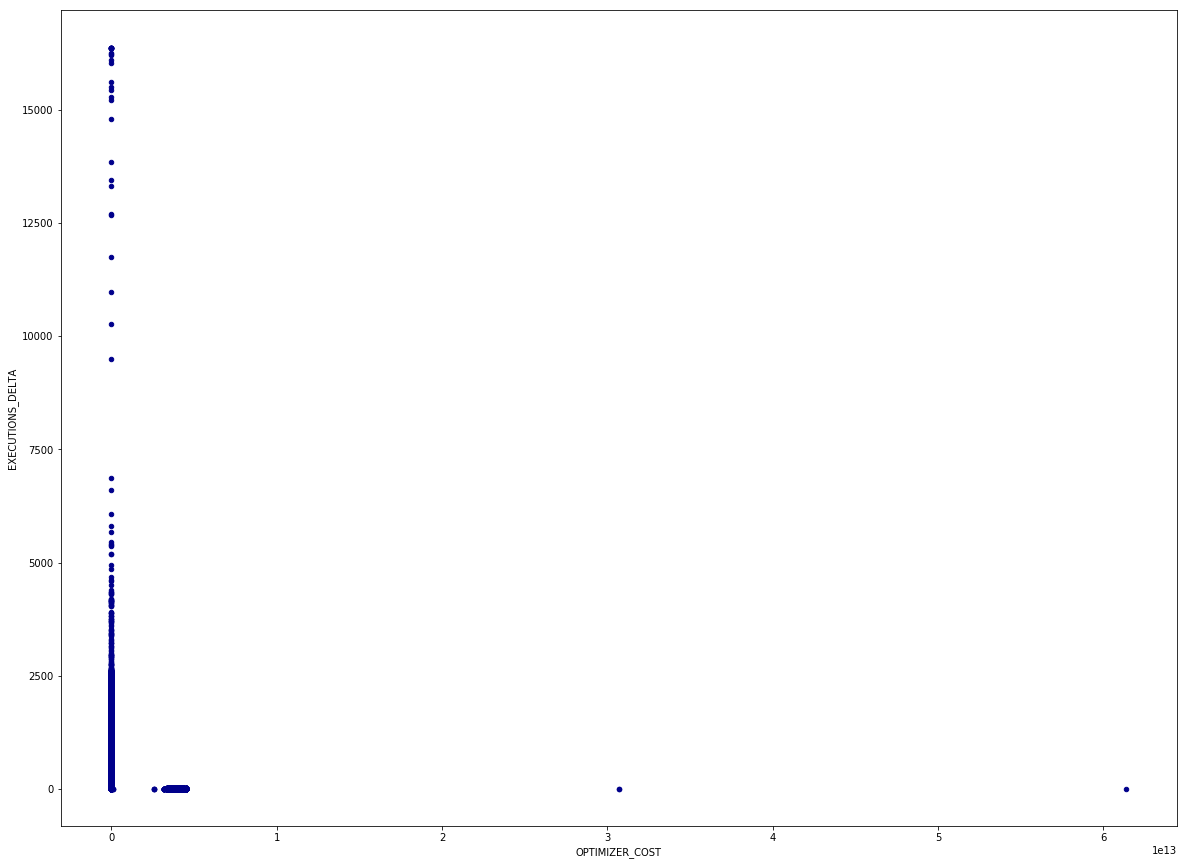

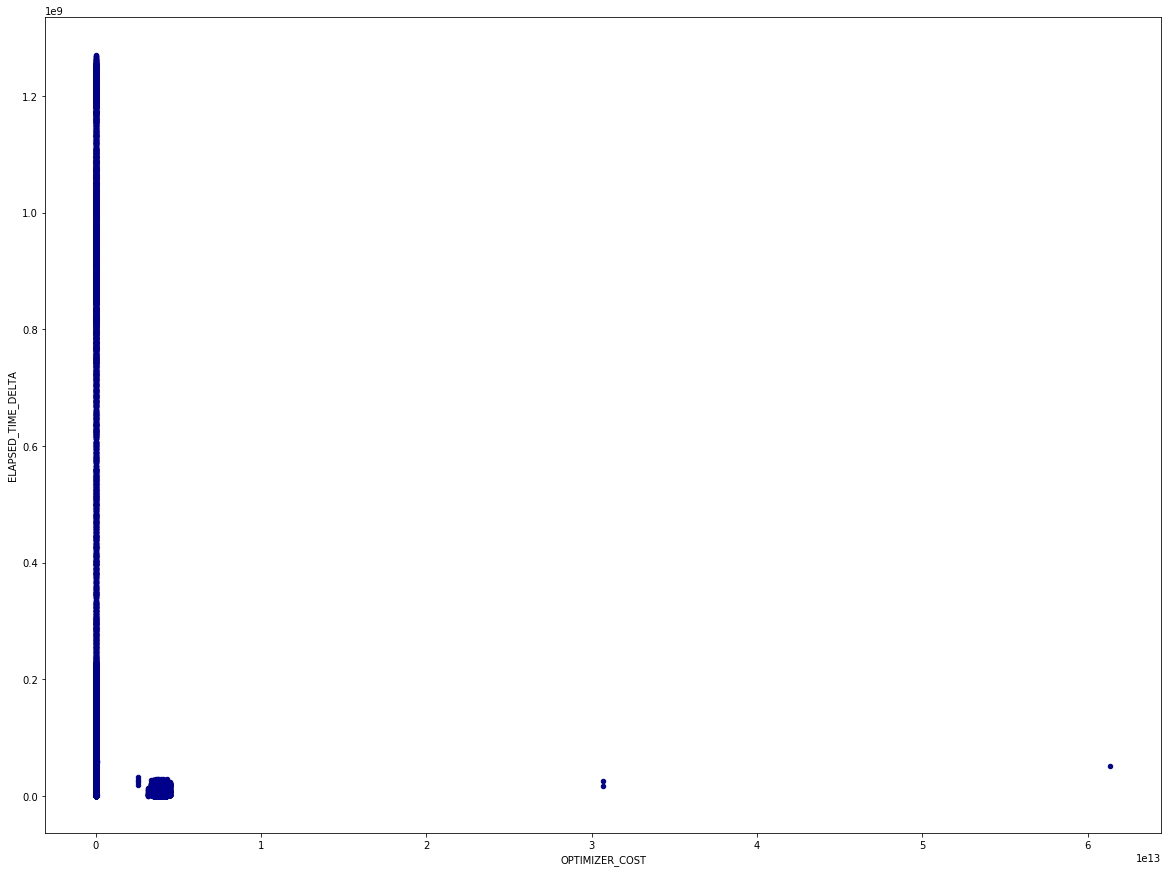

--------------------------------------------------------


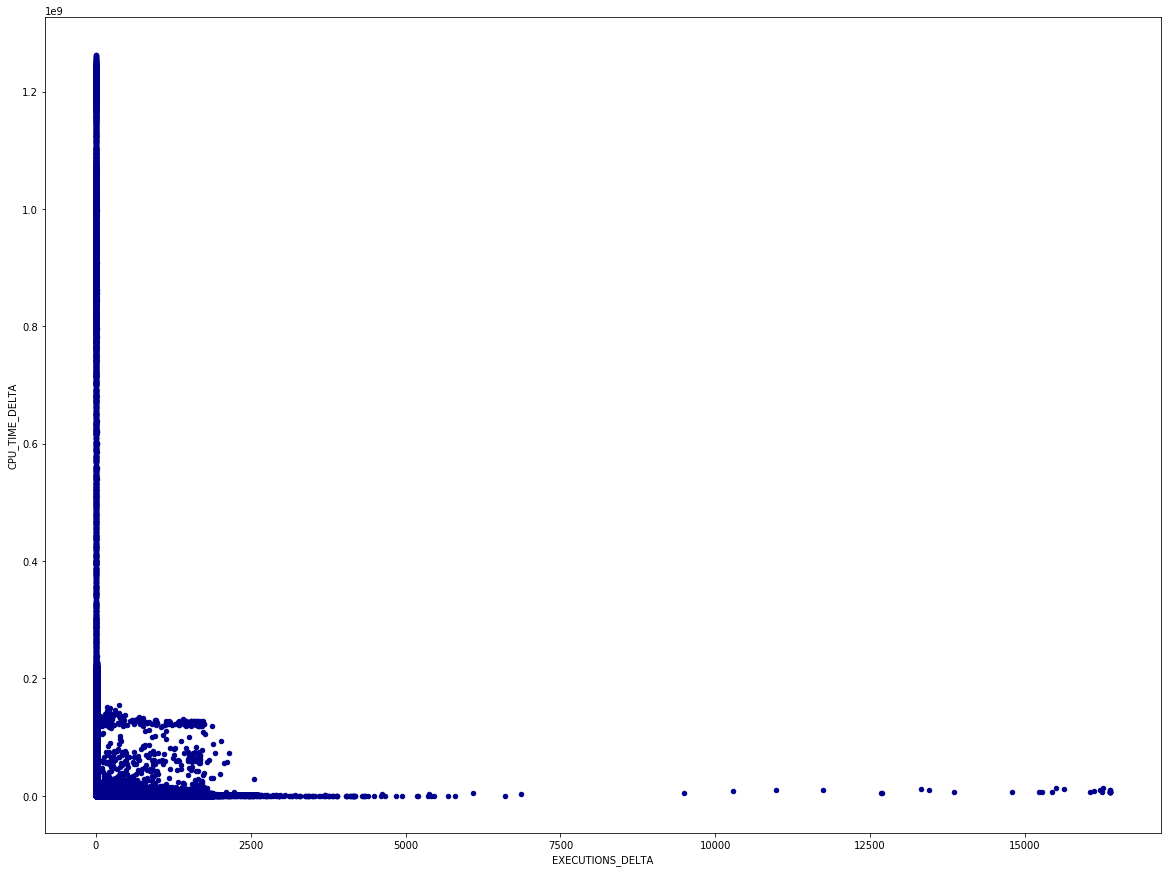

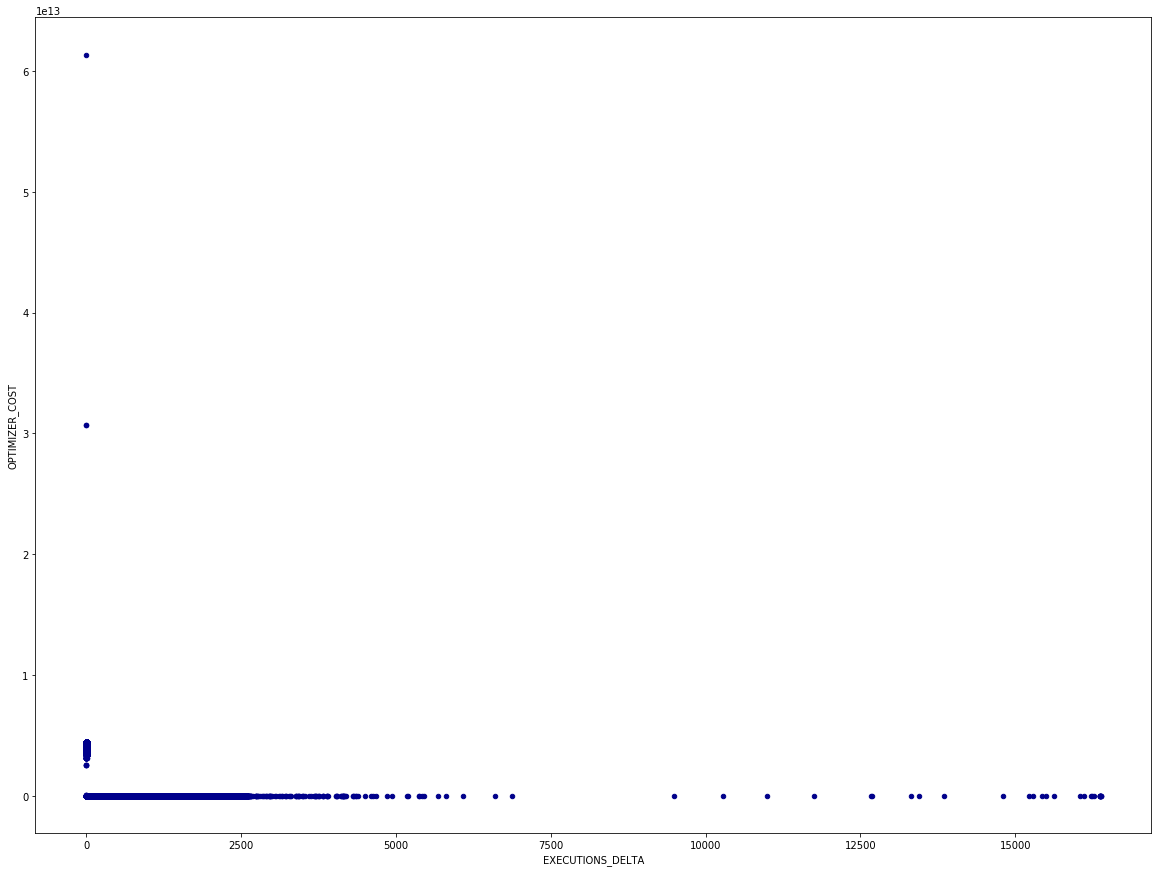

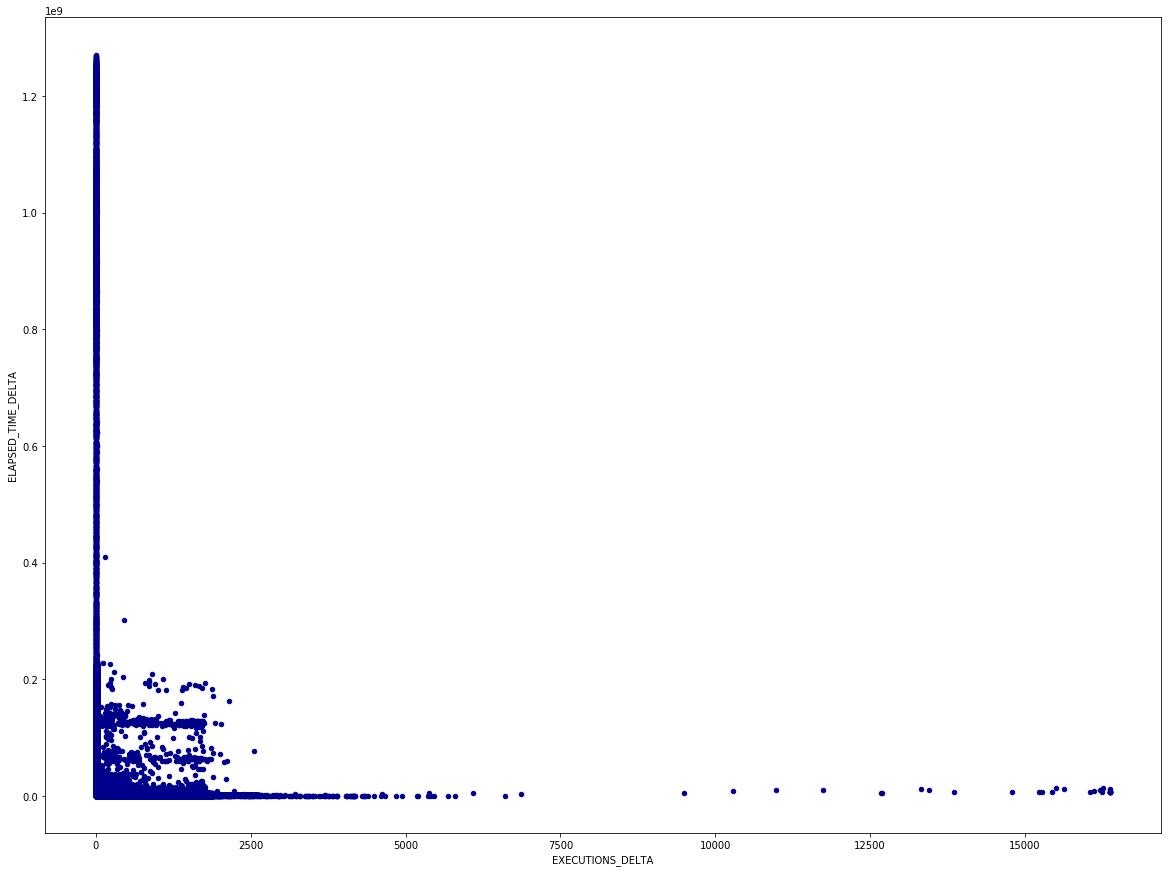

--------------------------------------------------------


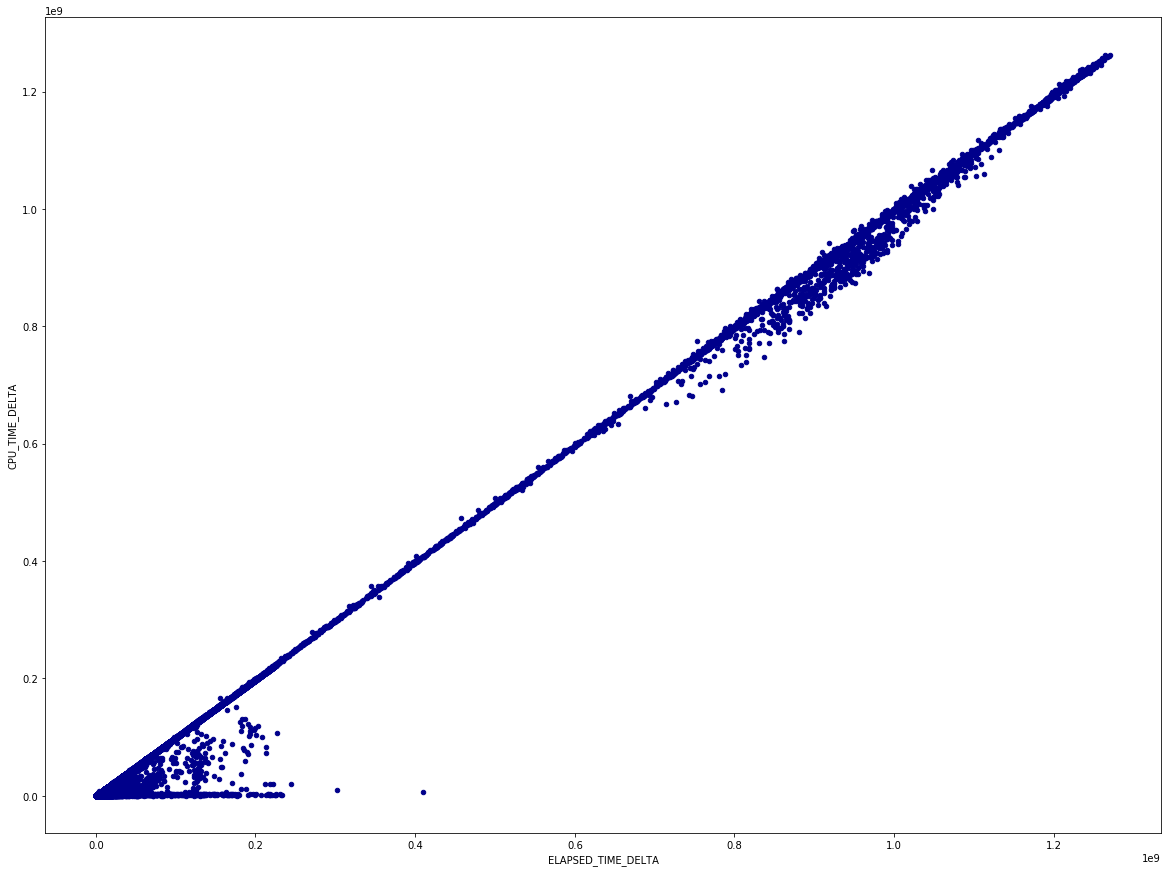

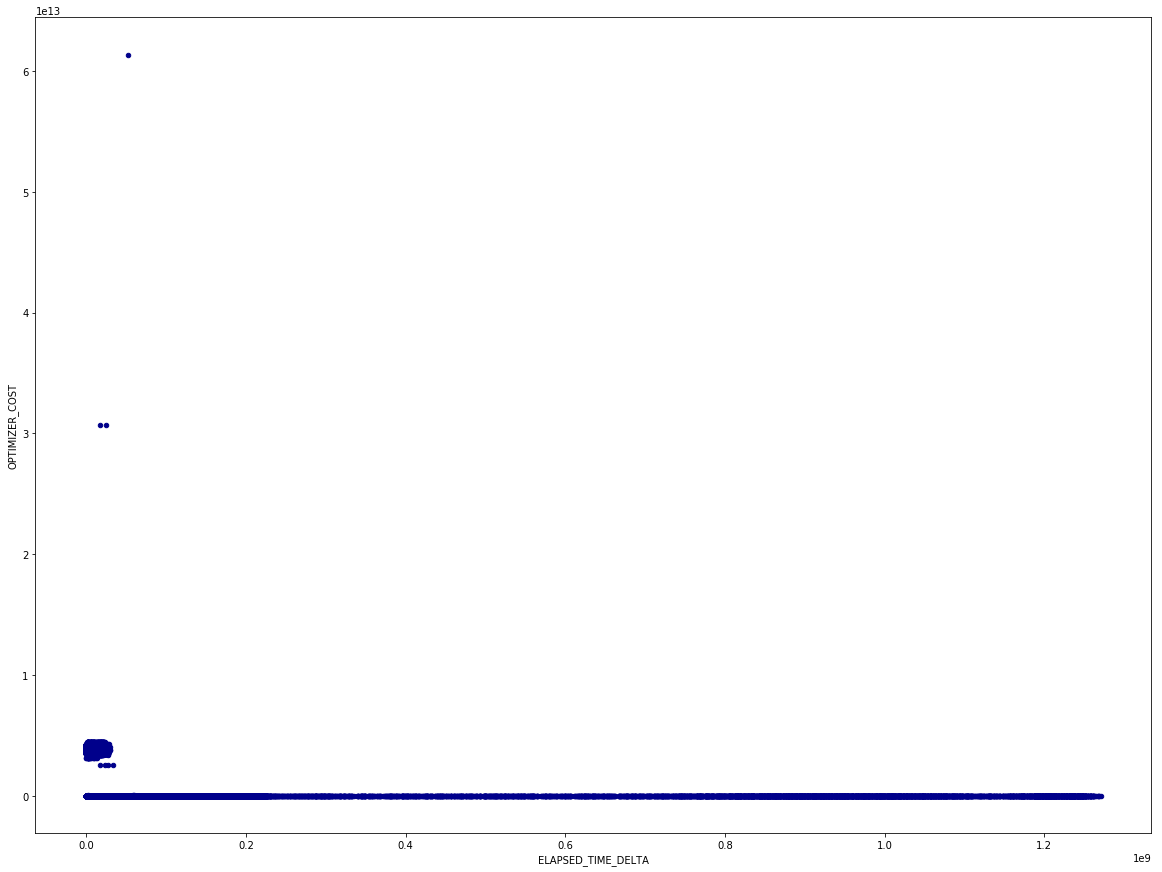

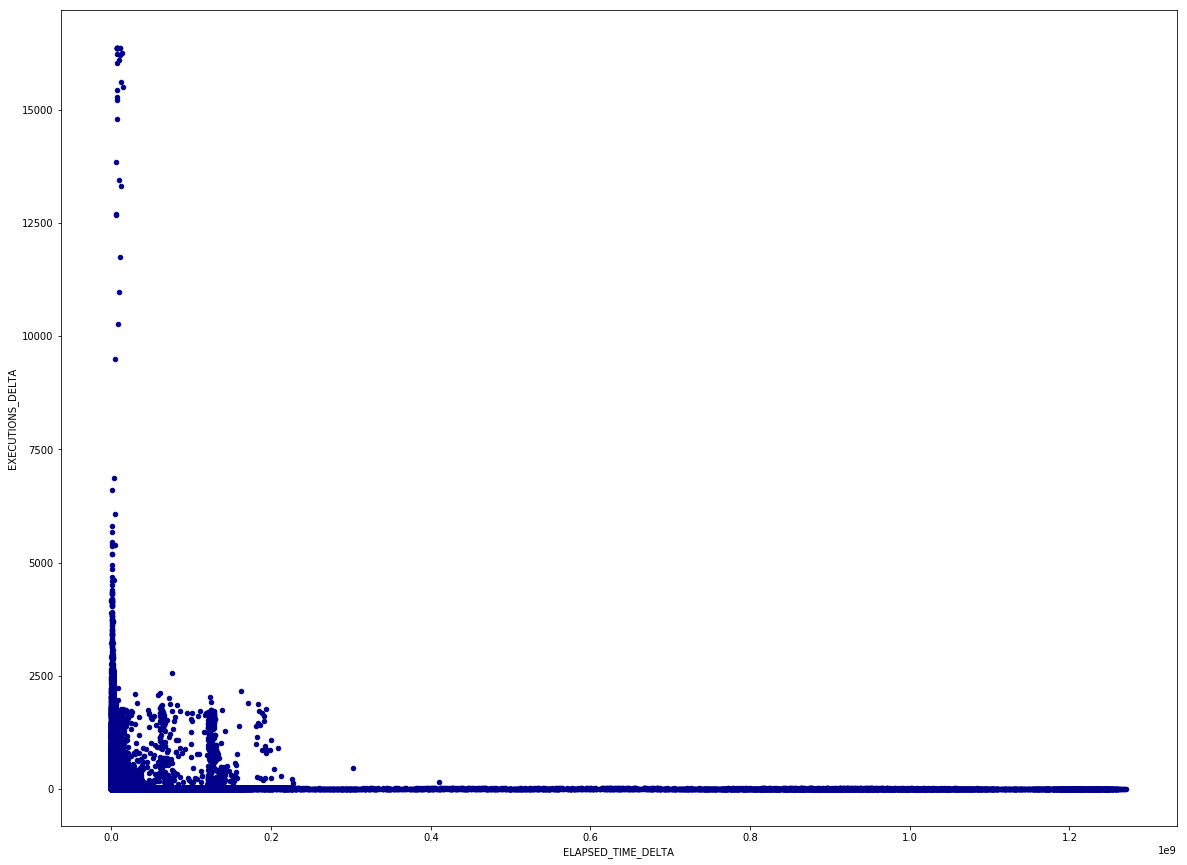

In [332]:
#y_label = ['CPU_TIME_DELTA','OPTIMIZER_COST','EXECUTIONS_DELTA','ELAPSED_TIME_DELTA']
plt.rcParams['figure.figsize'] = [20, 15]
rep_hist_snapshot_df.plot.scatter(x='CPU_TIME_DELTA',
                                  y='OPTIMIZER_COST',
                                  c='DarkBlue')
rep_hist_snapshot_df.plot.scatter(x='CPU_TIME_DELTA',
                                  y='EXECUTIONS_DELTA',
                                  c='DarkBlue')
rep_hist_snapshot_df.plot.scatter(x='CPU_TIME_DELTA',
                                  y='ELAPSED_TIME_DELTA',
                                  c='DarkBlue')
plt.show()
print('--------------------------------------------------------')
rep_hist_snapshot_df.plot.scatter(x='OPTIMIZER_COST',
                                  y='CPU_TIME_DELTA',
                                  c='DarkBlue')
rep_hist_snapshot_df.plot.scatter(x='OPTIMIZER_COST',
                                  y='EXECUTIONS_DELTA',
                                  c='DarkBlue')
rep_hist_snapshot_df.plot.scatter(x='OPTIMIZER_COST',
                                  y='ELAPSED_TIME_DELTA',
                                  c='DarkBlue')
plt.show()
print('--------------------------------------------------------')
rep_hist_snapshot_df.plot.scatter(x='EXECUTIONS_DELTA',
                                  y='CPU_TIME_DELTA',
                                  c='DarkBlue')
rep_hist_snapshot_df.plot.scatter(x='EXECUTIONS_DELTA',
                                  y='OPTIMIZER_COST',
                                  c='DarkBlue')
rep_hist_snapshot_df.plot.scatter(x='EXECUTIONS_DELTA',
                                  y='ELAPSED_TIME_DELTA',
                                  c='DarkBlue')
plt.show()
print('--------------------------------------------------------')
rep_hist_snapshot_df.plot.scatter(x='ELAPSED_TIME_DELTA',
                                  y='CPU_TIME_DELTA',
                                  c='DarkBlue')
rep_hist_snapshot_df.plot.scatter(x='ELAPSED_TIME_DELTA',
                                  y='OPTIMIZER_COST',
                                  c='DarkBlue')
rep_hist_snapshot_df.plot.scatter(x='ELAPSED_TIME_DELTA',
                                  y='EXECUTIONS_DELTA',
                                  c='DarkBlue')
plt.show()

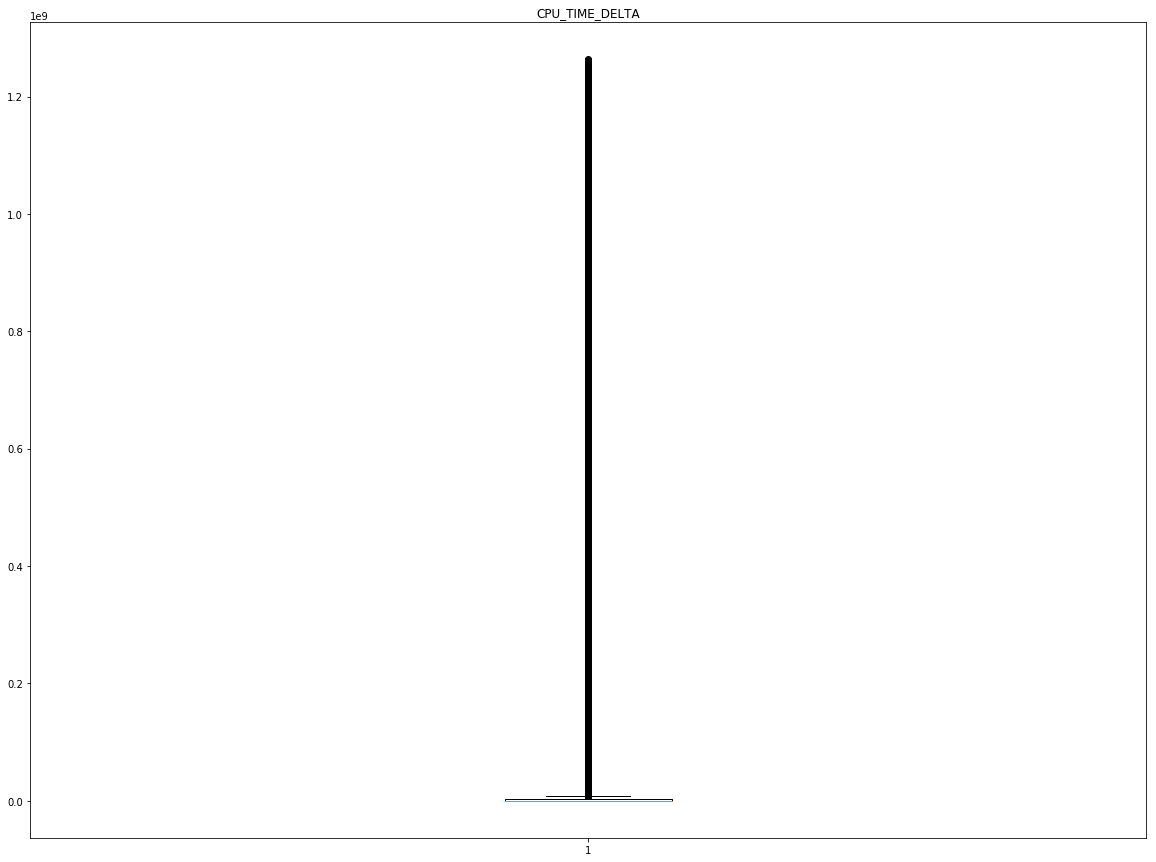

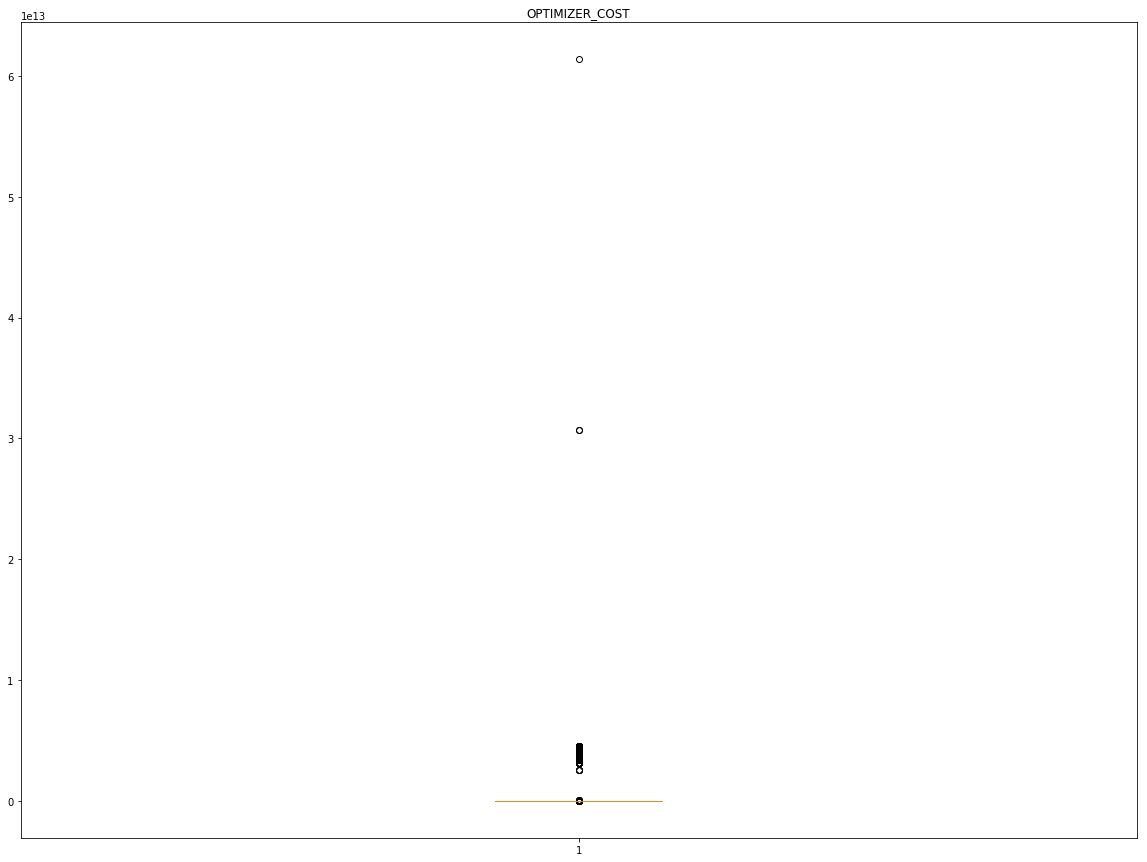

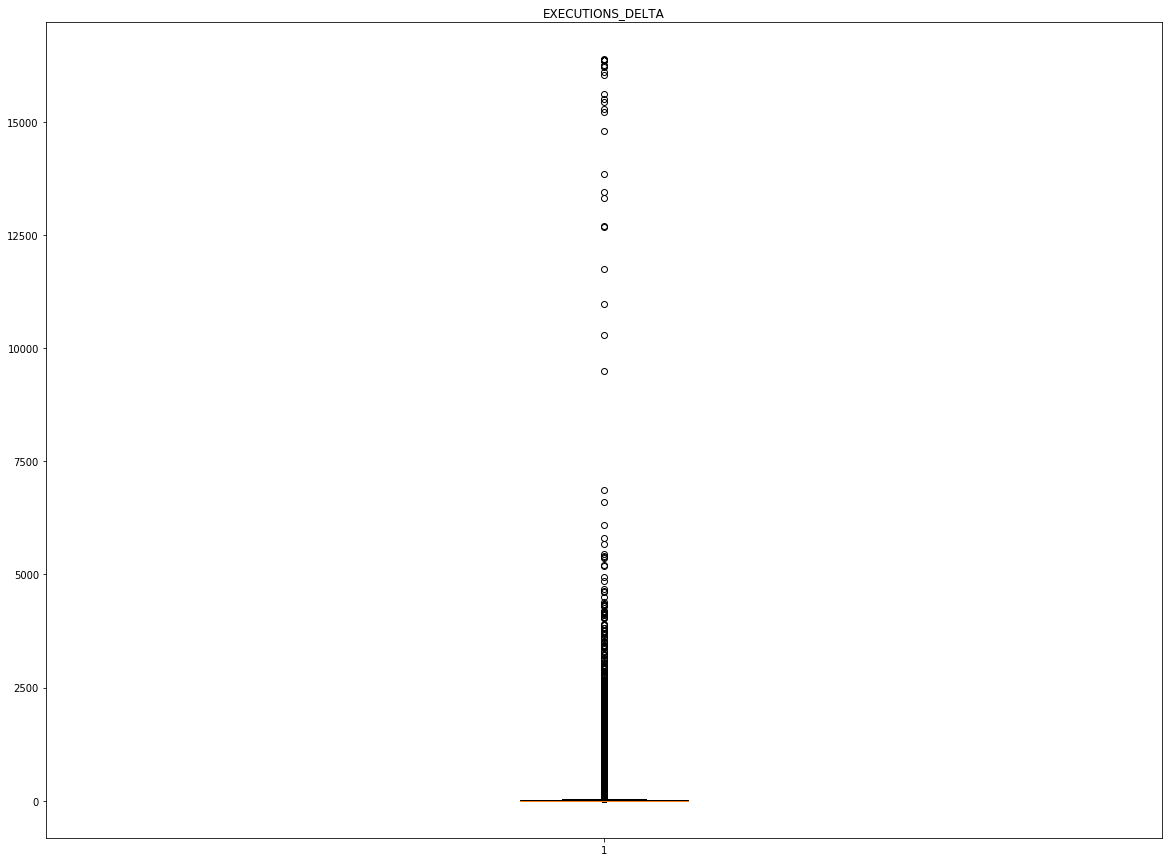

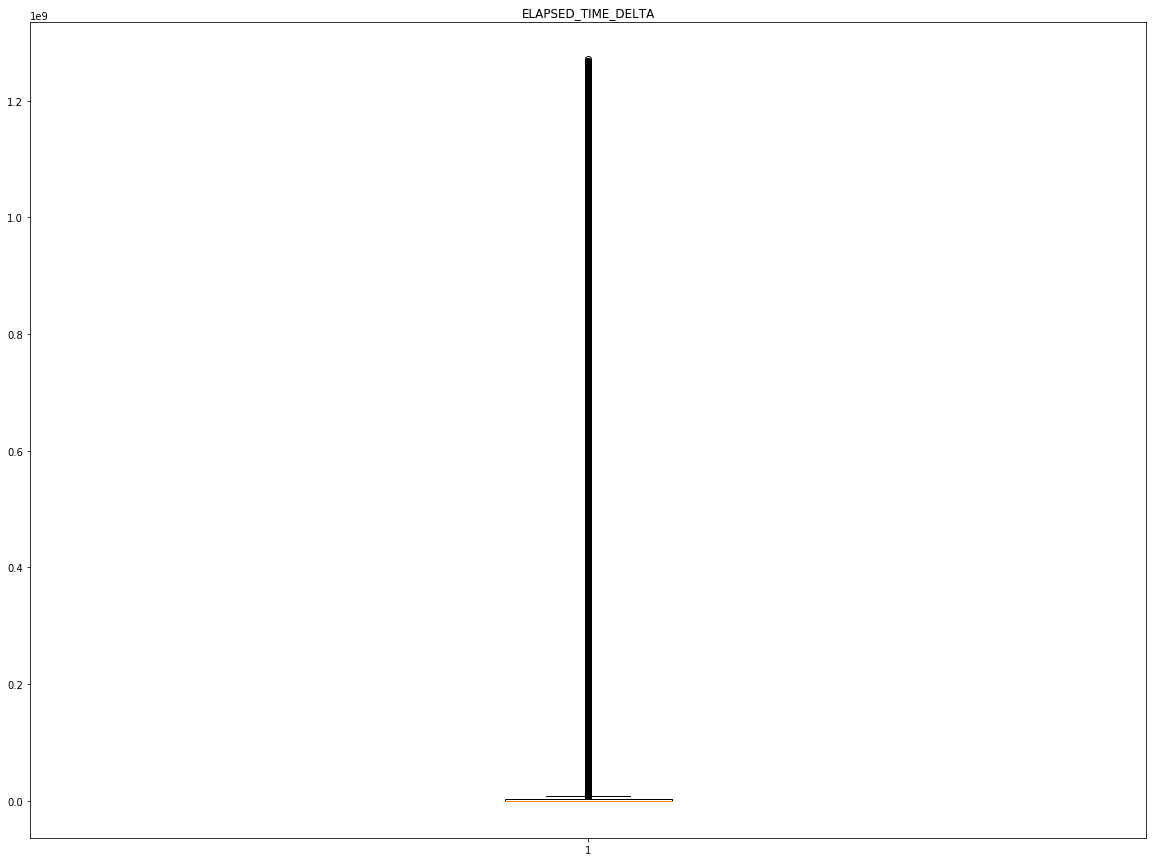

In [333]:
plt.rcParams['figure.figsize'] = [20, 15]
plt.boxplot(rep_hist_snapshot_df['CPU_TIME_DELTA'].values)
plt.title('CPU_TIME_DELTA')
plt.show()
plt.boxplot(rep_hist_snapshot_df['OPTIMIZER_COST'].values)
plt.title('OPTIMIZER_COST')
plt.show()
plt.boxplot(rep_hist_snapshot_df['EXECUTIONS_DELTA'].values)
plt.title('EXECUTIONS_DELTA')
plt.show()
plt.boxplot(rep_hist_snapshot_df['ELAPSED_TIME_DELTA'].values)
plt.title('ELAPSED_TIME_DELTA')
plt.show()

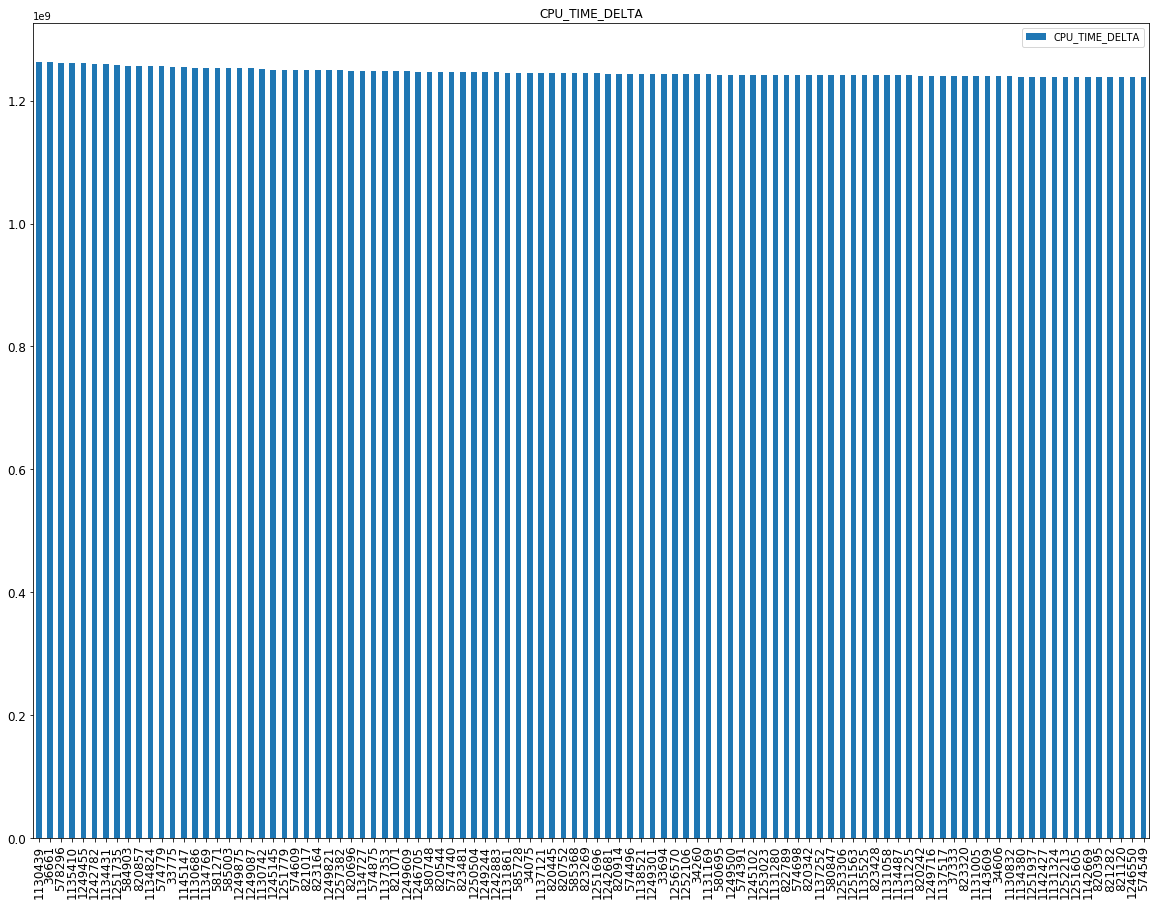

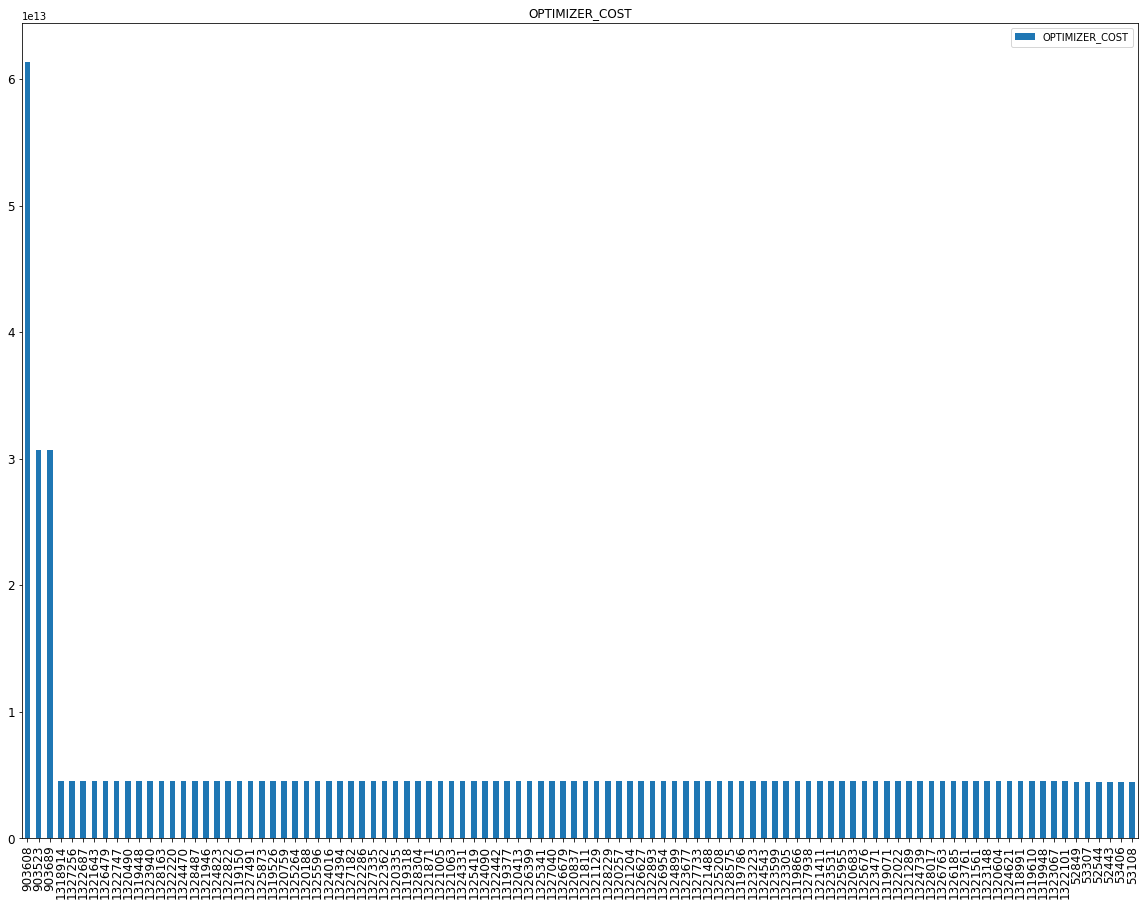

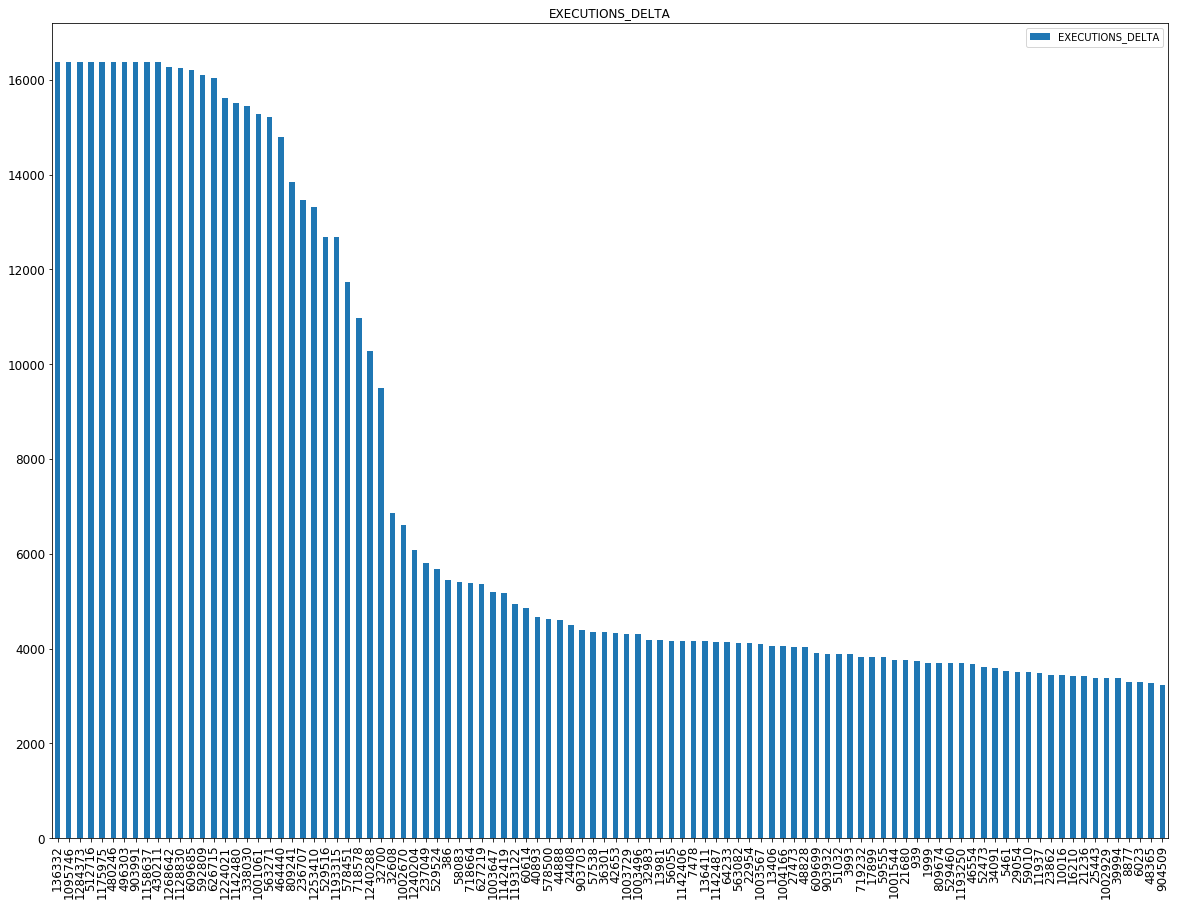

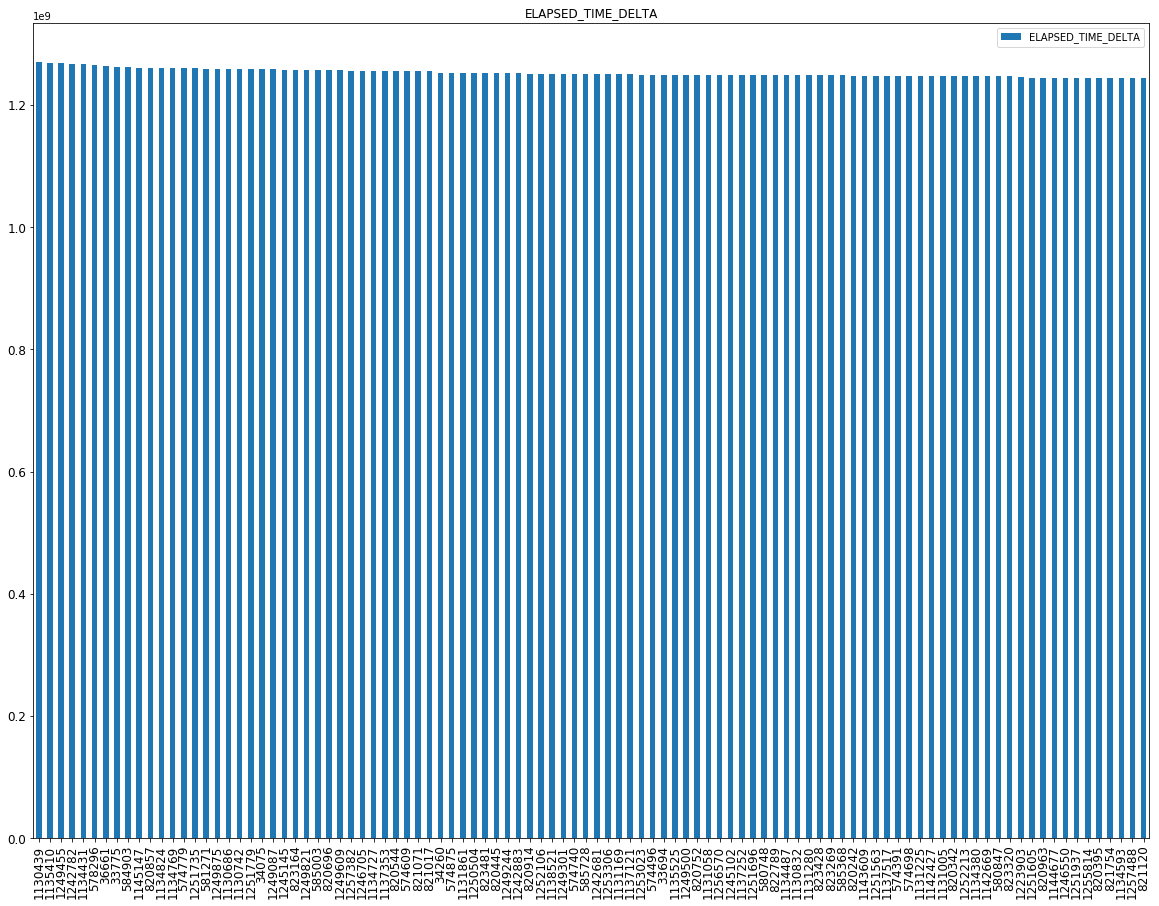

In [334]:
limit = 100
label = 'CPU_TIME_DELTA'
rep_hist_snapshot_df2 = rep_hist_snapshot_df.sort_values(by=label, ascending=False)
rep_hist_snapshot_df2[[label]][0:limit].plot(kind='bar', title =label, figsize=(20, 15), legend=True, fontsize=12)
label = 'OPTIMIZER_COST'
rep_hist_snapshot_df2 = rep_hist_snapshot_df.sort_values(by=label, ascending=False)
rep_hist_snapshot_df2[[label]][0:limit].plot(kind='bar', title =label, figsize=(20, 15), legend=True, fontsize=12)
label = 'EXECUTIONS_DELTA'
rep_hist_snapshot_df2 = rep_hist_snapshot_df.sort_values(by=label, ascending=False,)
rep_hist_snapshot_df2[[label]][0:limit].plot(kind='bar', title =label, figsize=(20, 15), legend=True, fontsize=12)
label = 'ELAPSED_TIME_DELTA'
rep_hist_snapshot_df2 = rep_hist_snapshot_df.sort_values(by=label, ascending=False)
rep_hist_snapshot_df2[[label]][0:limit].plot(kind='bar', title =label, figsize=(20, 15), legend=True, fontsize=12)
plt.show()

### Guaging Outliers (REP_VSQL_PLAN)

Uses the following labels and plots them, so as to showcase the presence of outliers:
* COST
* CARDINALITY
* BYTES
* CPU_COST
* IO_COST
* TEMP_SPACE
* TIME

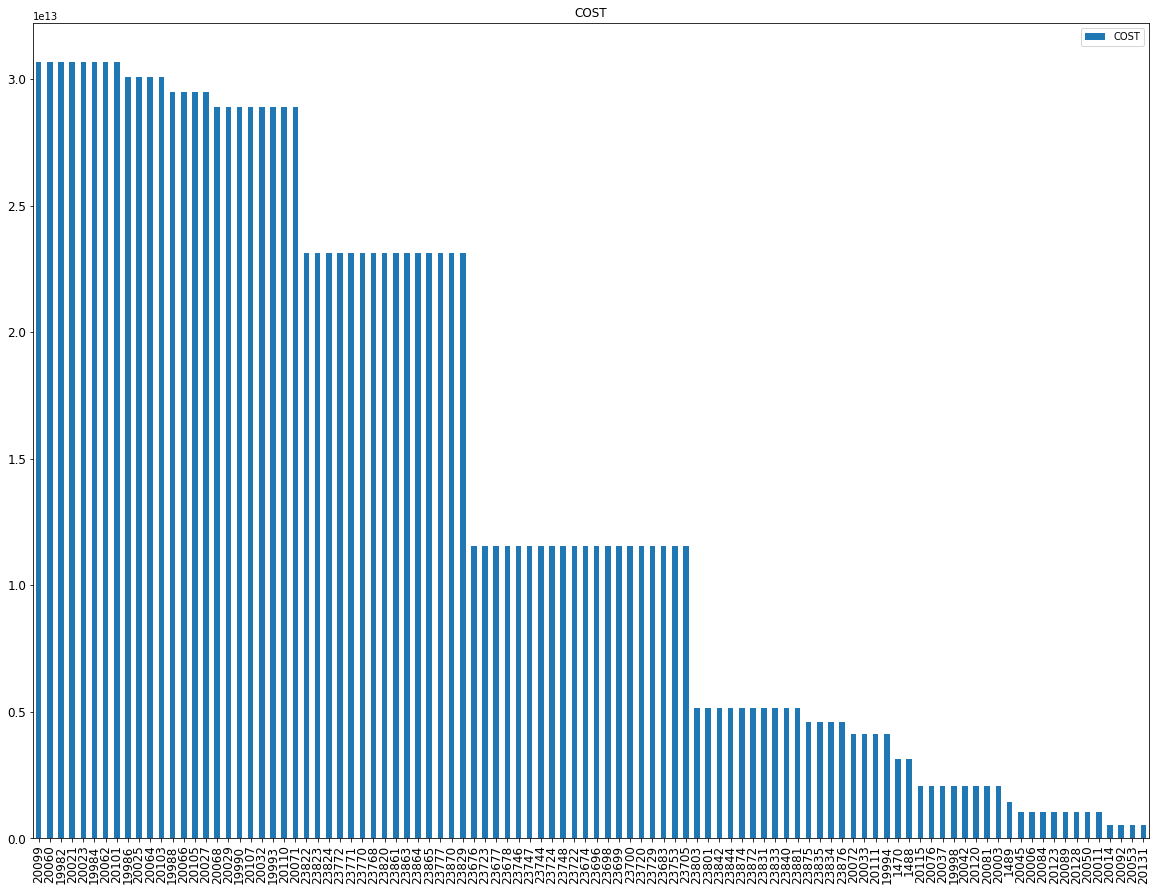

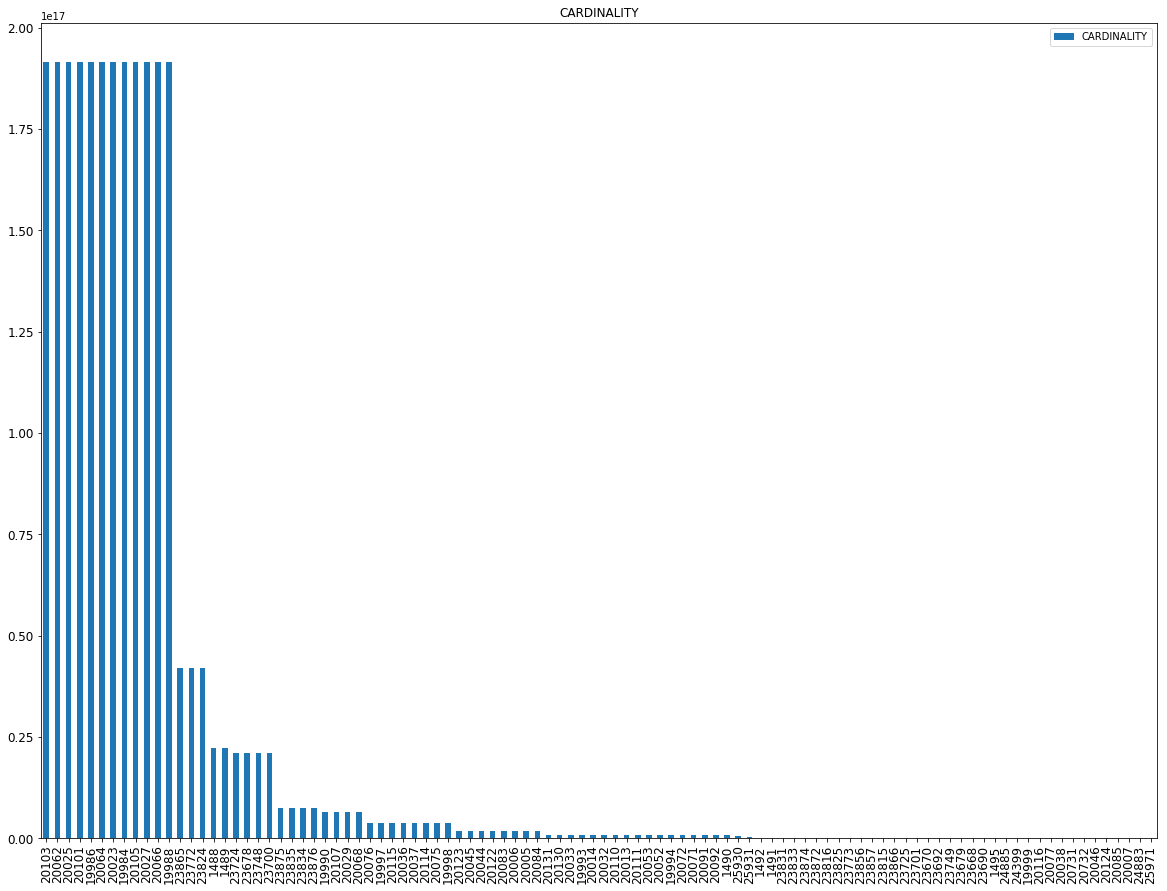

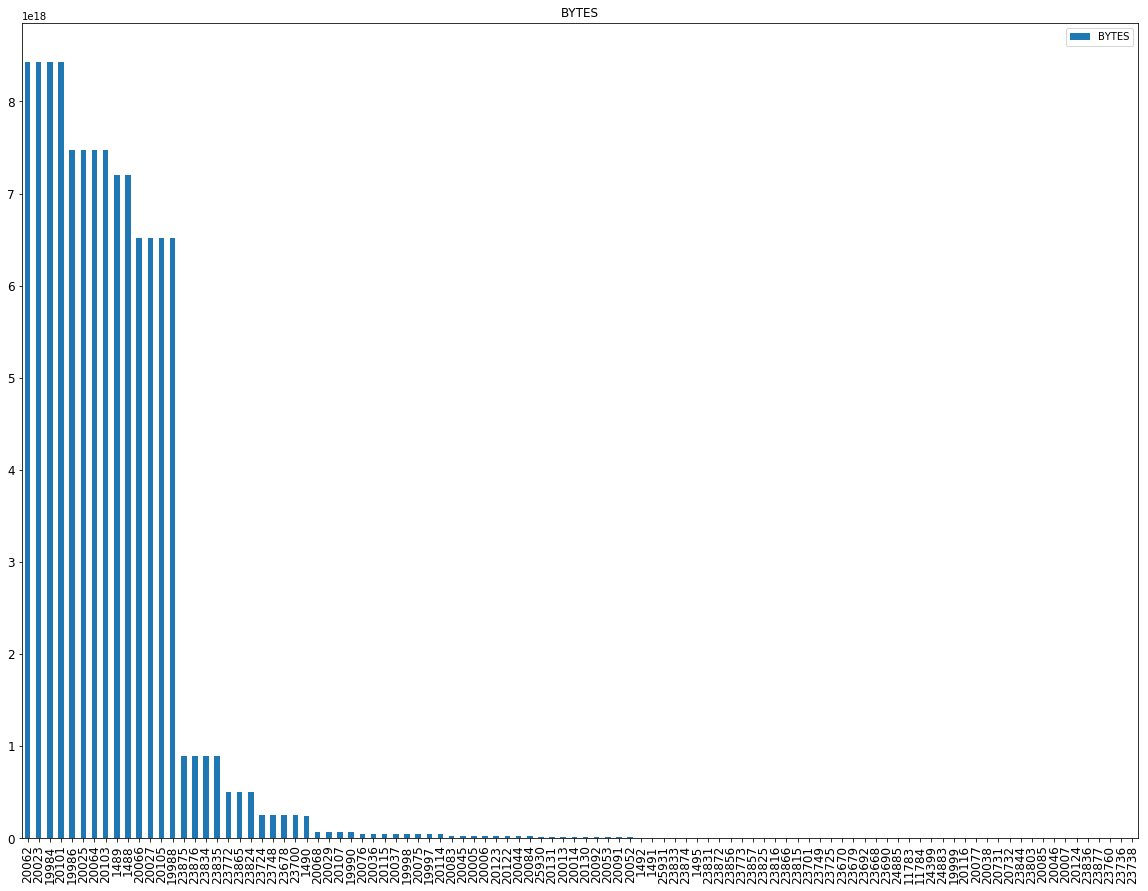

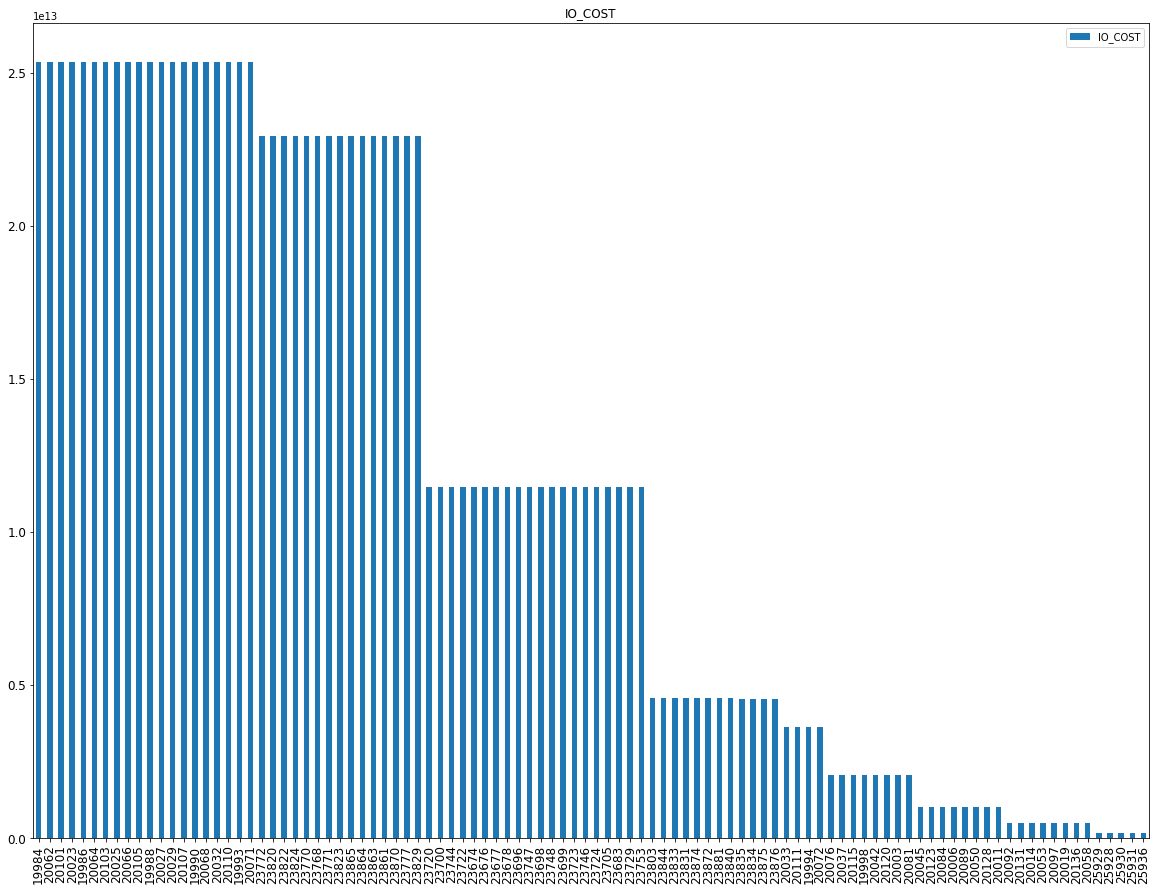

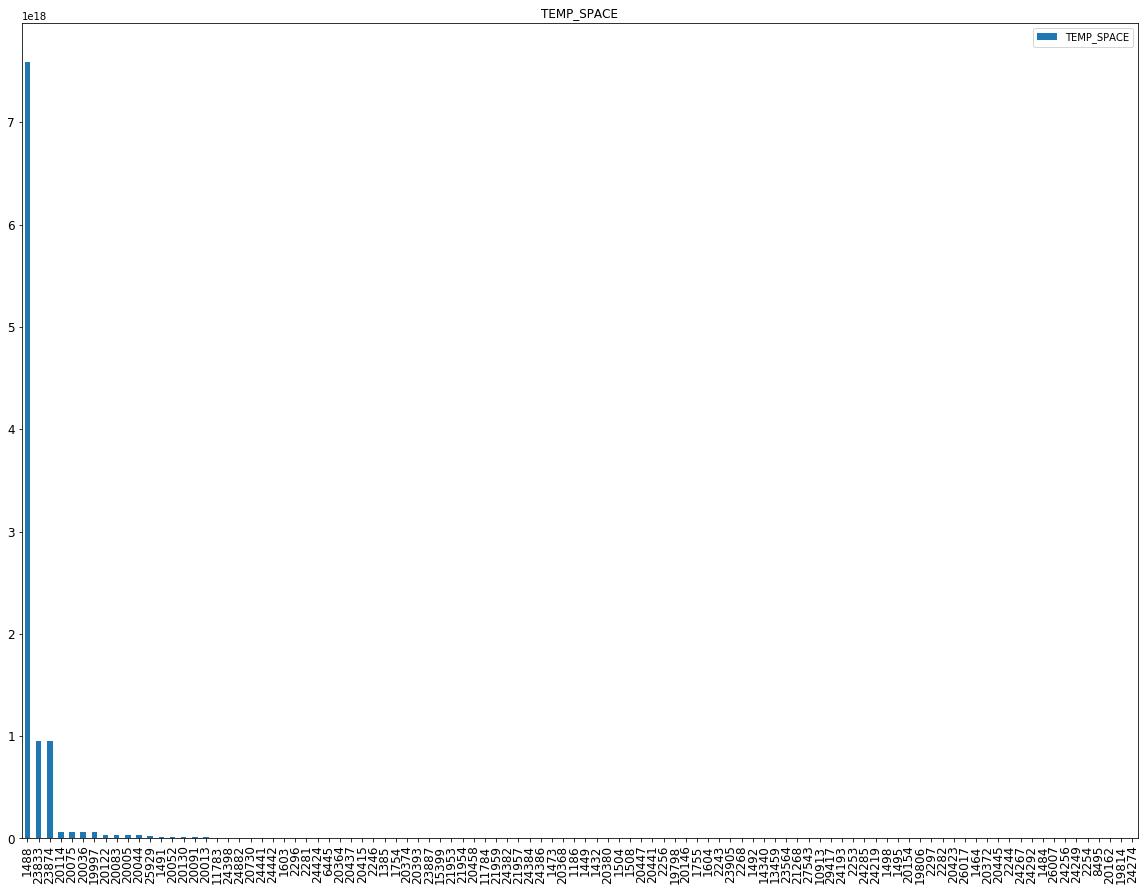

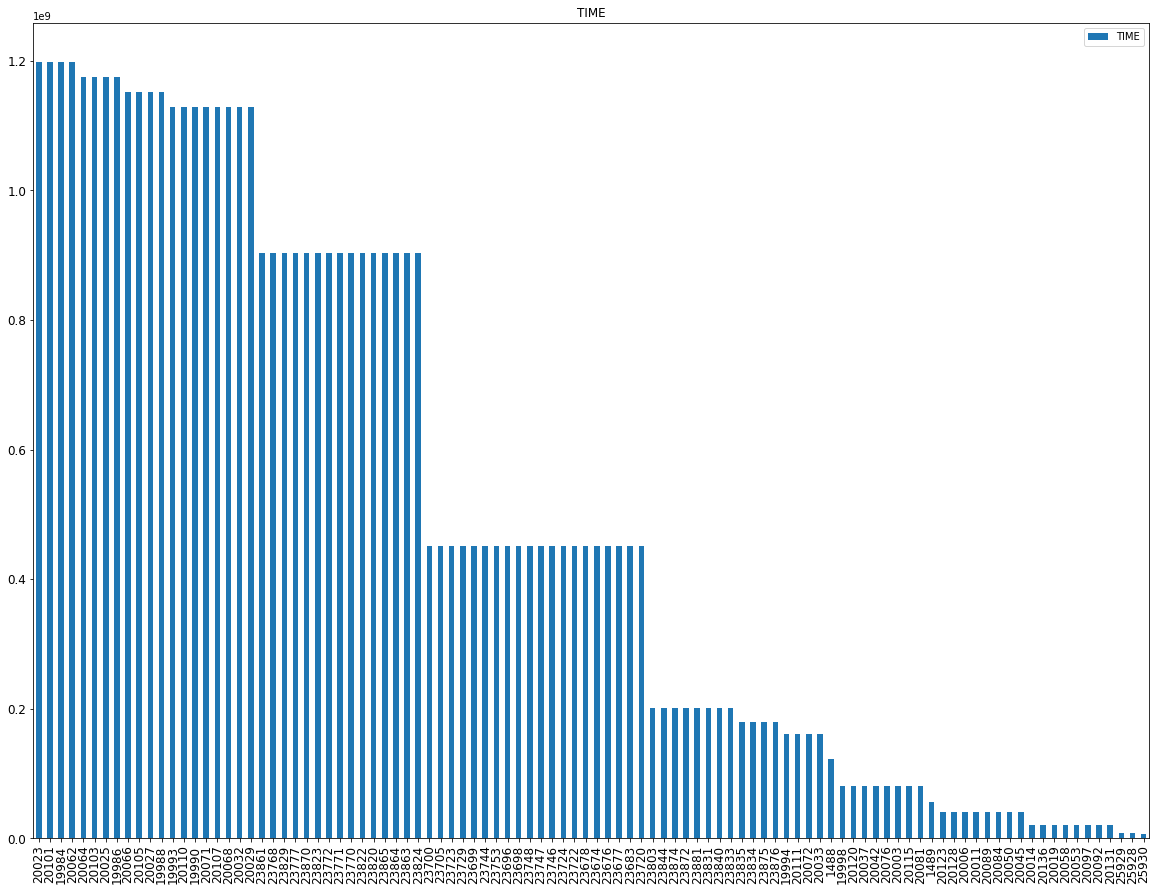

In [335]:
limit = 100
label = 'COST'
rep_vsql_plan_df2 = rep_vsql_plan_df.sort_values(by=label, ascending=False)
rep_vsql_plan_df2[[label]][0:limit].plot(kind='bar', title =label, figsize=(20, 15), legend=True, fontsize=12)
label = 'CARDINALITY'
rep_vsql_plan_df2 = rep_vsql_plan_df.sort_values(by=label, ascending=False)
rep_vsql_plan_df2[[label]][0:limit].plot(kind='bar', title =label, figsize=(20, 15), legend=True, fontsize=12)
label = 'BYTES'
rep_vsql_plan_df2 = rep_vsql_plan_df.sort_values(by=label, ascending=False)
rep_vsql_plan_df2[[label]][0:limit].plot(kind='bar', title =label, figsize=(20, 15), legend=True, fontsize=12)
label = 'IO_COST'
rep_vsql_plan_df2 = rep_vsql_plan_df.sort_values(by=label, ascending=False)
rep_vsql_plan_df2[[label]][0:limit].plot(kind='bar', title =label, figsize=(20, 15), legend=True, fontsize=12)
label = 'TEMP_SPACE'
rep_vsql_plan_df2 = rep_vsql_plan_df.sort_values(by=label, ascending=False)
rep_vsql_plan_df2[[label]][0:limit].plot(kind='bar', title =label, figsize=(20, 15), legend=True, fontsize=12)
label = 'TIME'
rep_vsql_plan_df2 = rep_vsql_plan_df.sort_values(by=label, ascending=False)
rep_vsql_plan_df2[[label]][0:limit].plot(kind='bar', title =label, figsize=(20, 15), legend=True, fontsize=12)
plt.show()

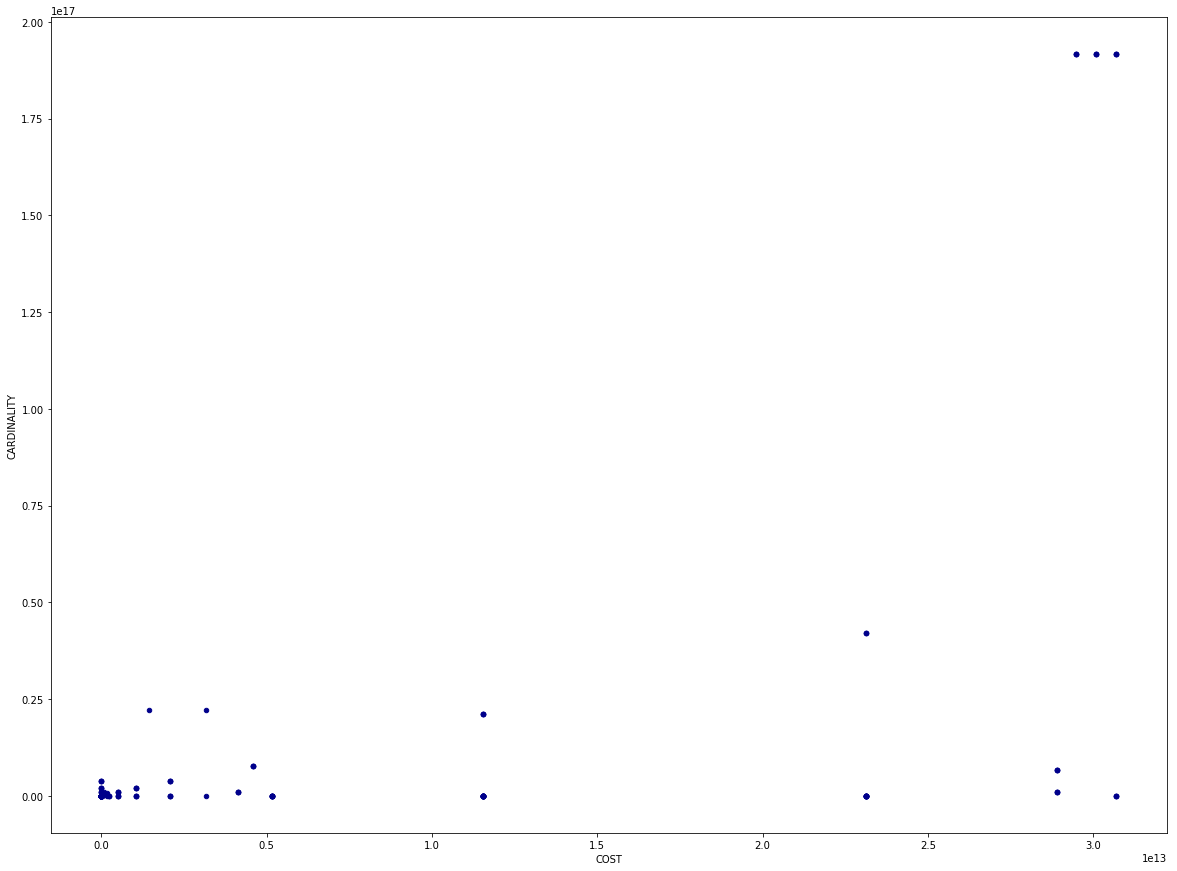

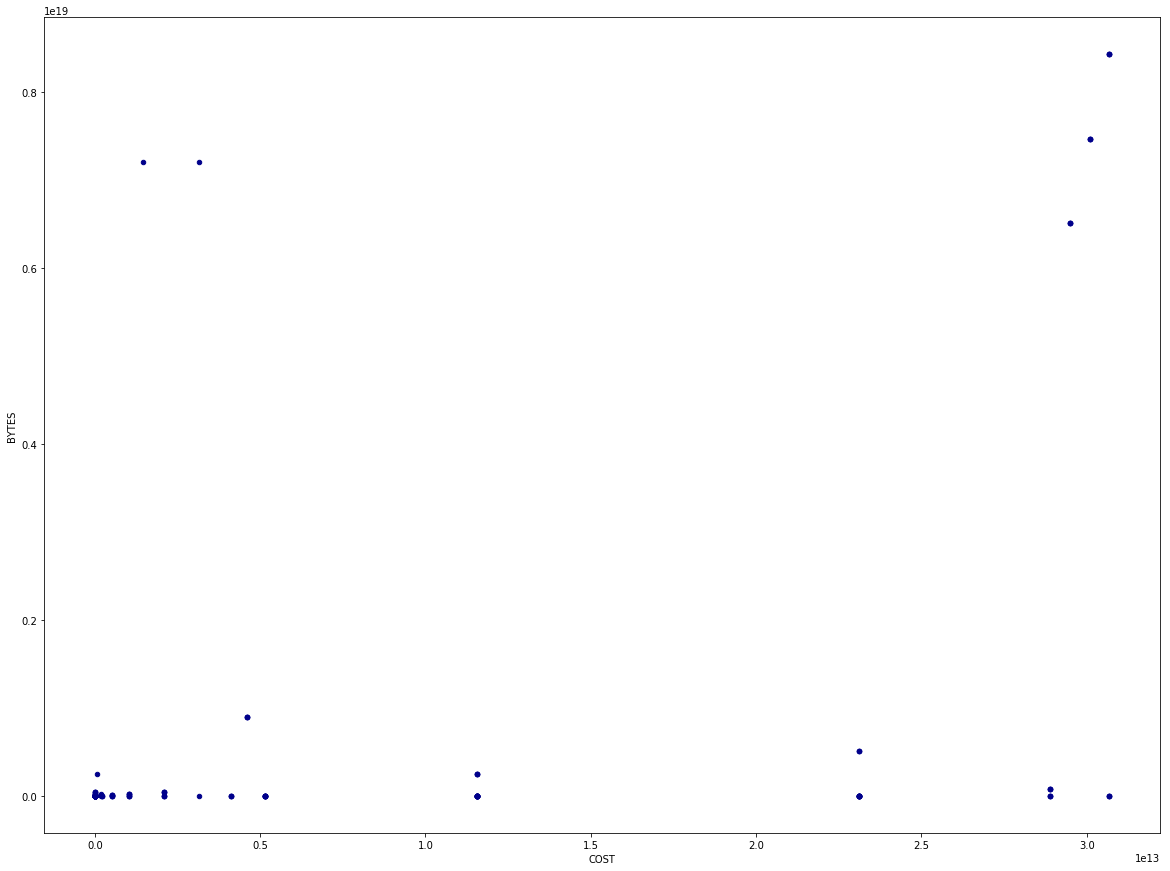

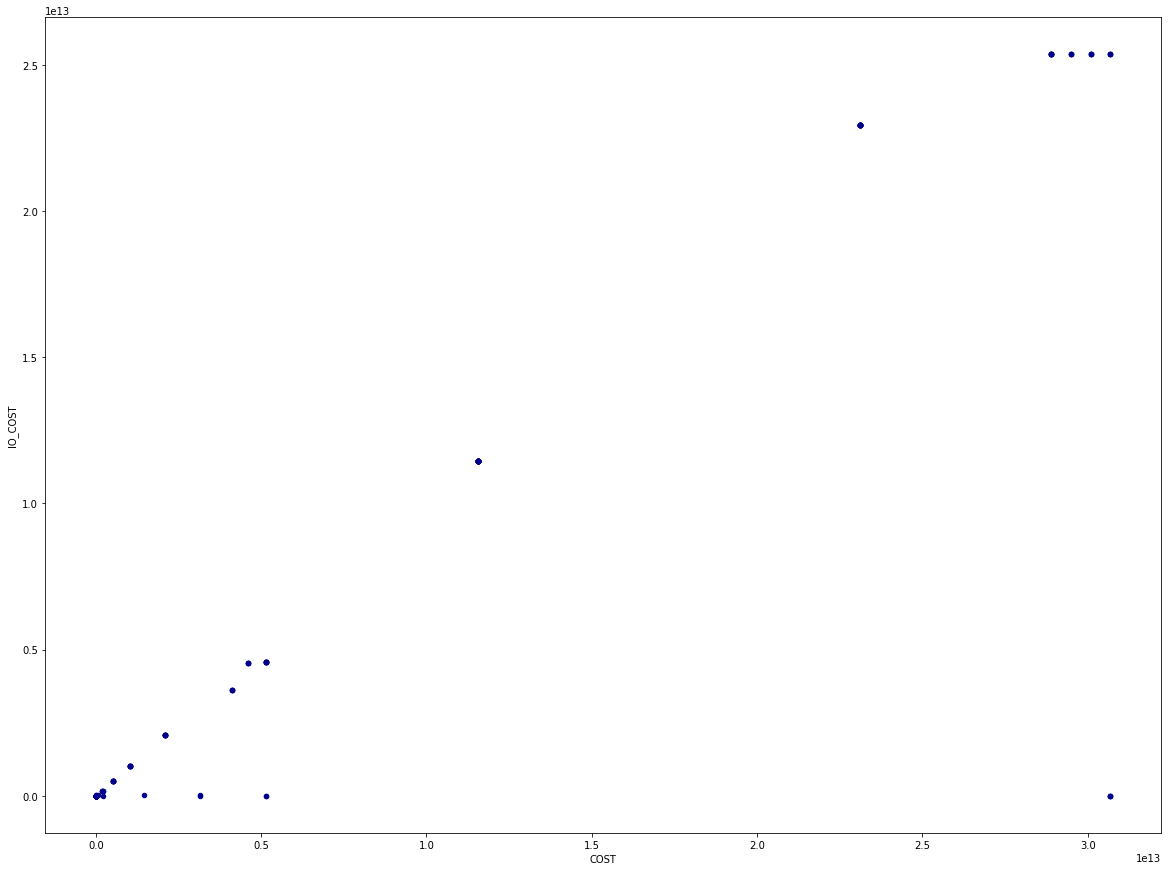

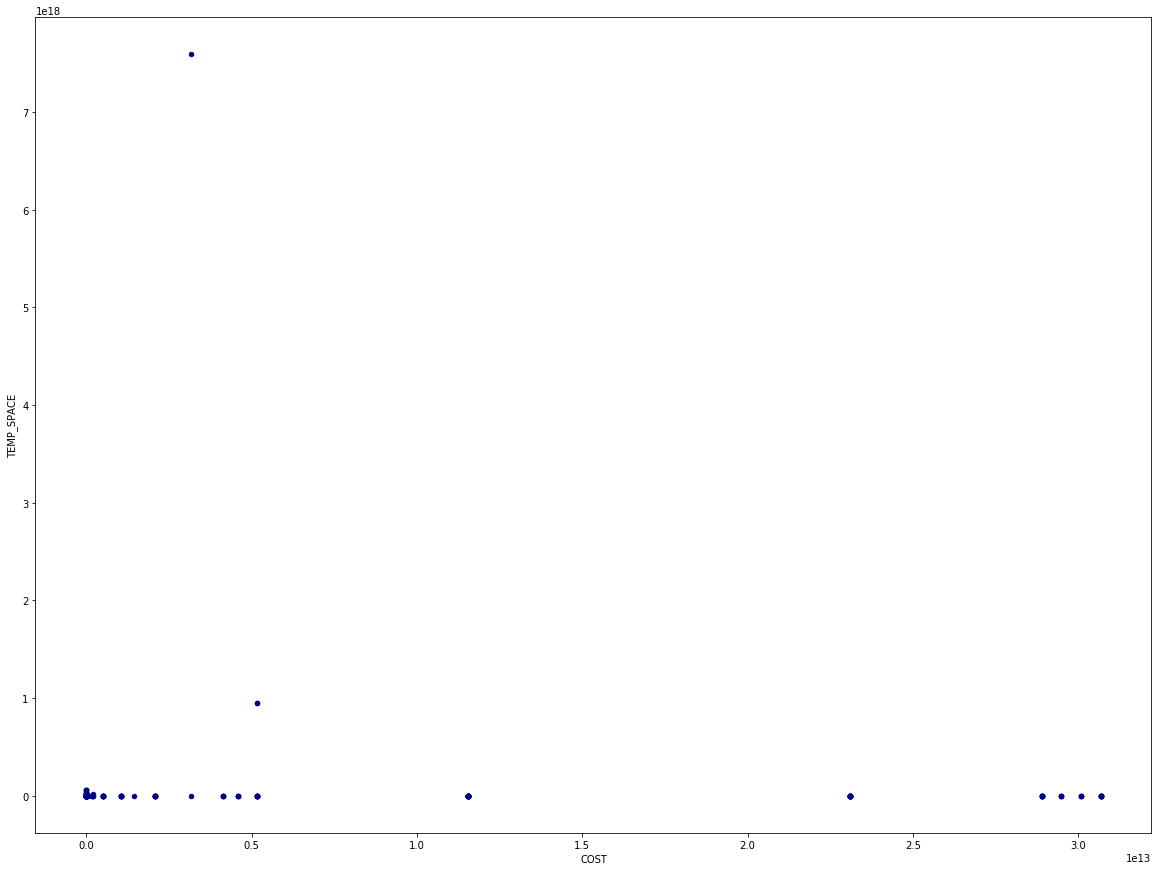

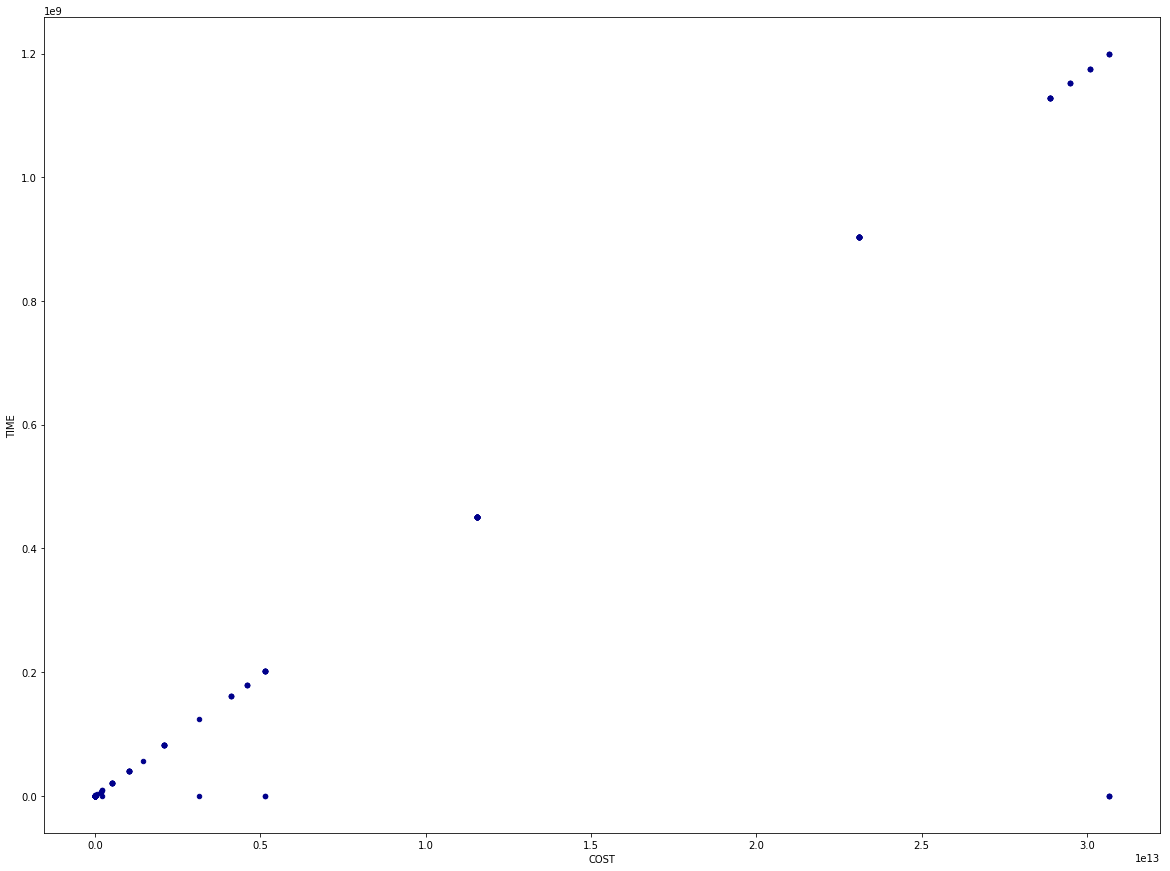

In [336]:
# y_label2 = ['COST','CARDINALITY','BYTES','IO_COST','TEMP_SPACE','TIME']
plt.rcParams['figure.figsize'] = [20, 15]
rep_vsql_plan_df.plot.scatter(x='COST',
                              y='CARDINALITY',
                              c='DarkBlue')
rep_vsql_plan_df.plot.scatter(x='COST',
                              y='BYTES',
                              c='DarkBlue')
rep_vsql_plan_df.plot.scatter(x='COST',
                              y='IO_COST',
                              c='DarkBlue')
rep_vsql_plan_df.plot.scatter(x='COST',
                              y='TEMP_SPACE',
                              c='DarkBlue')
rep_vsql_plan_df.plot.scatter(x='COST',
                              y='TIME',
                              c='DarkBlue')
plt.show()

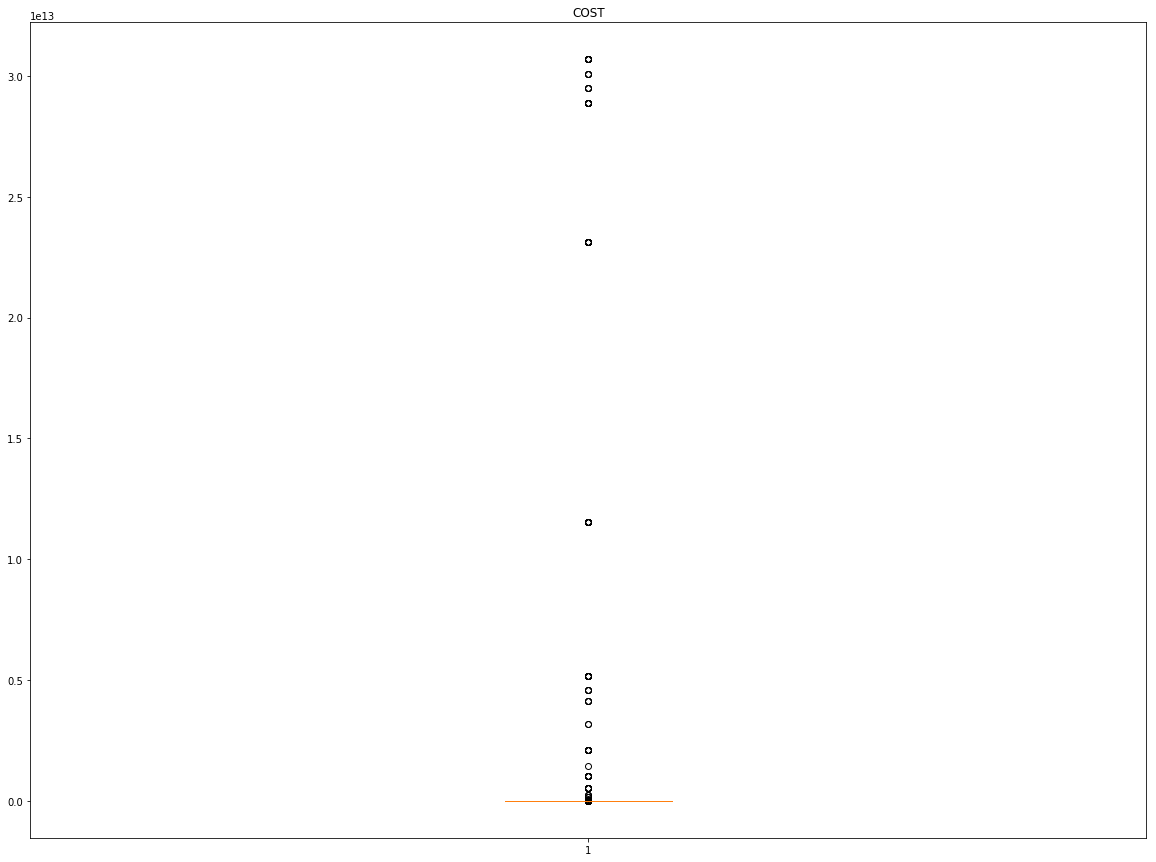

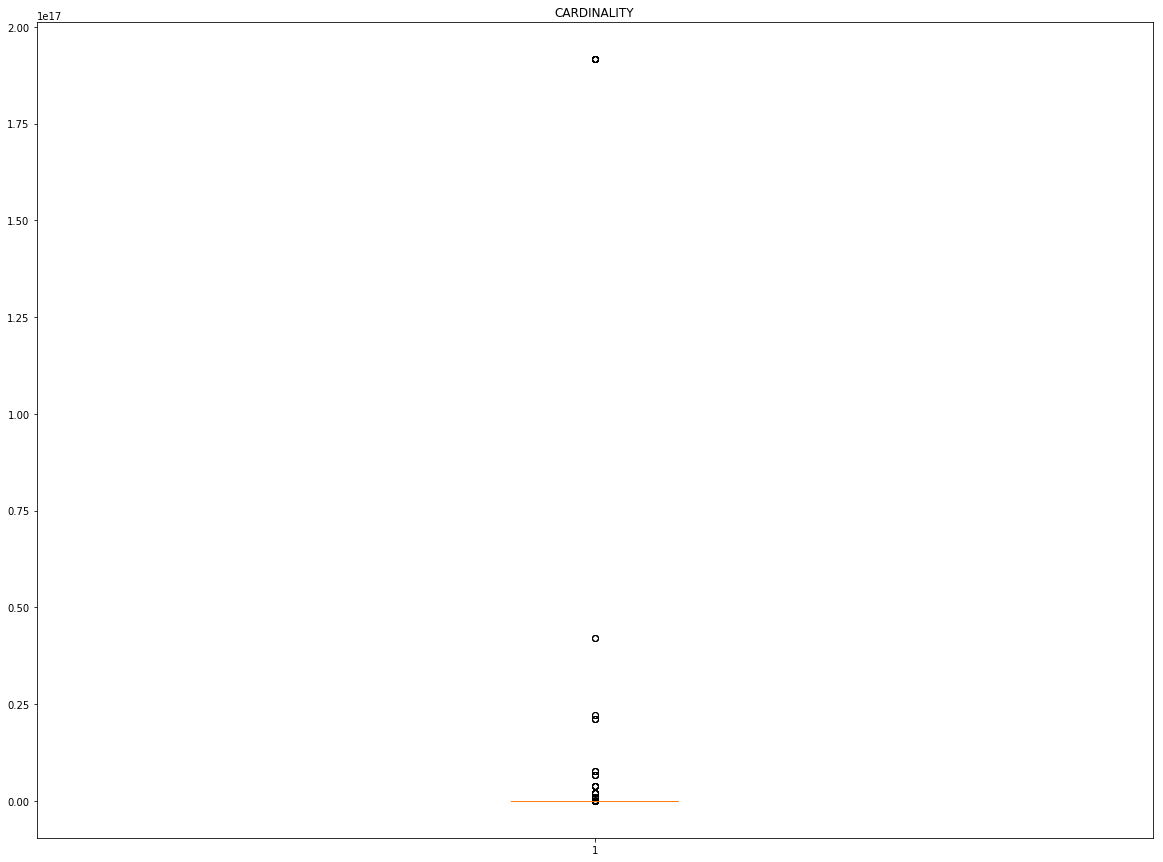

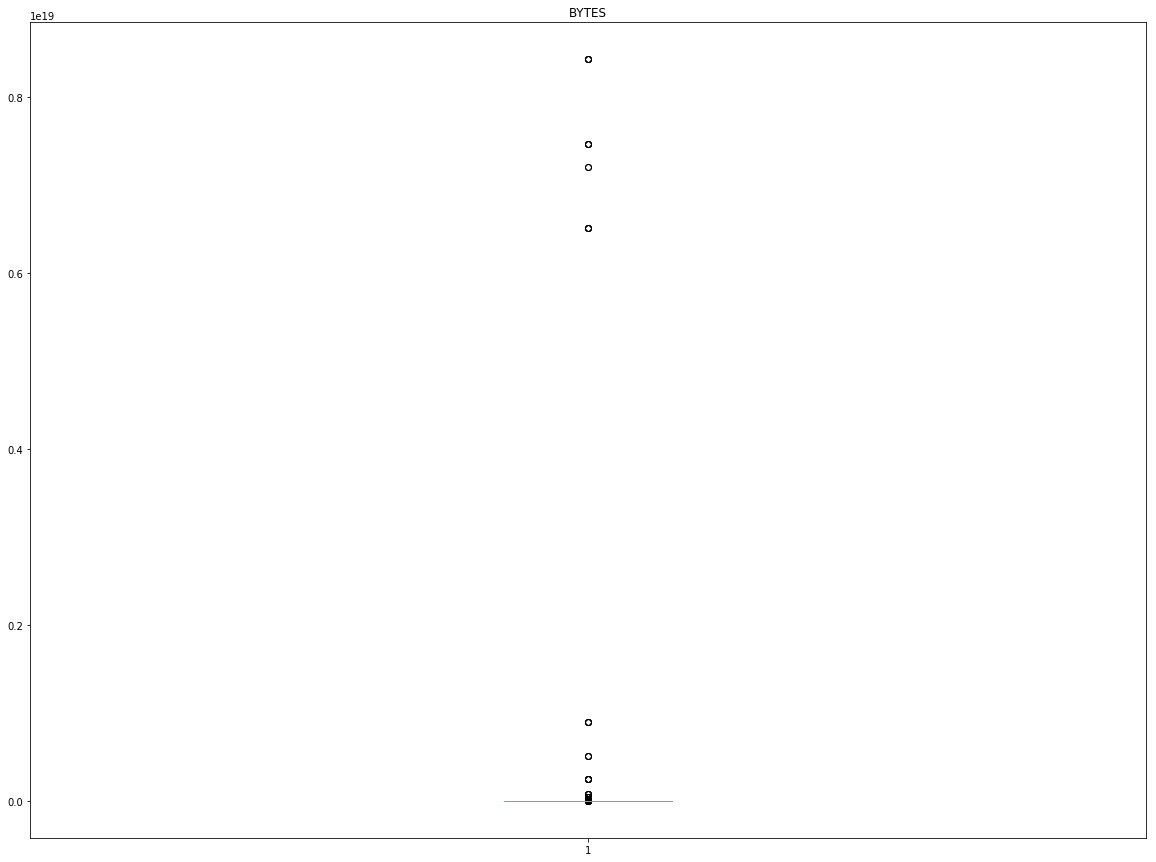

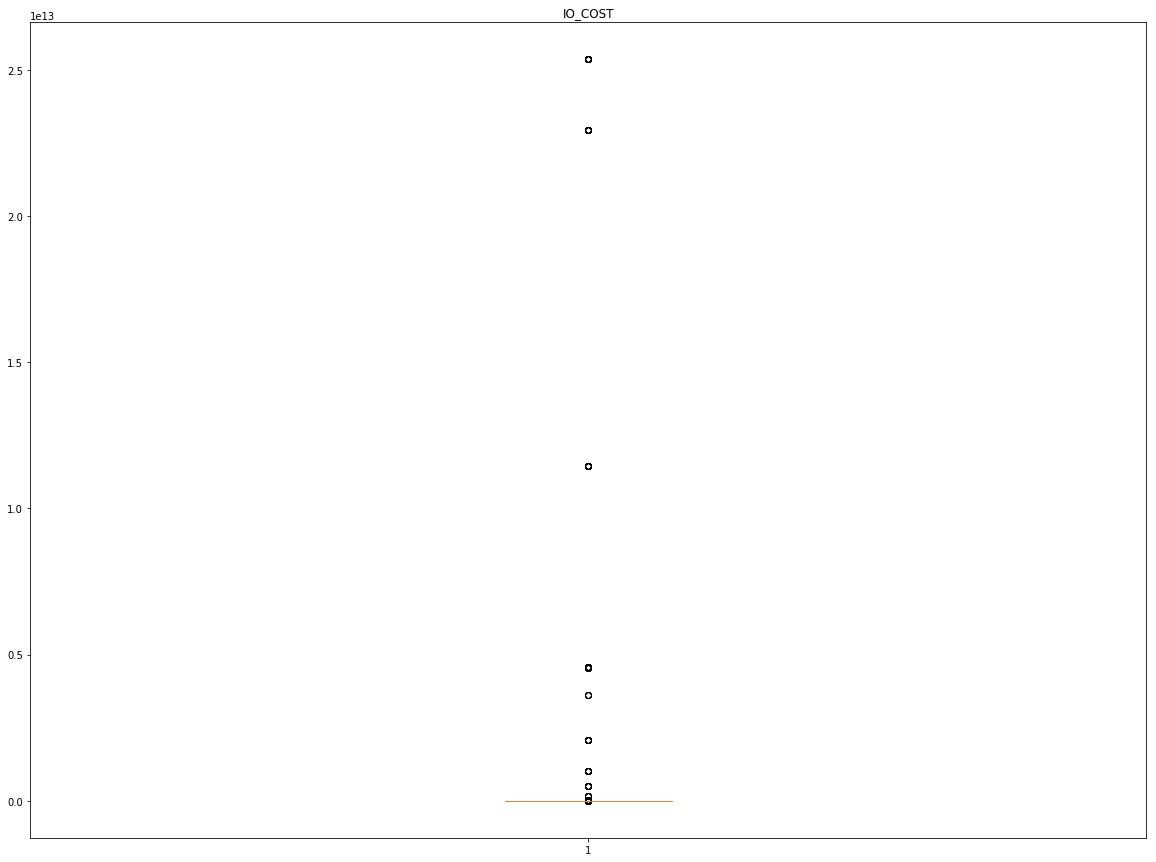

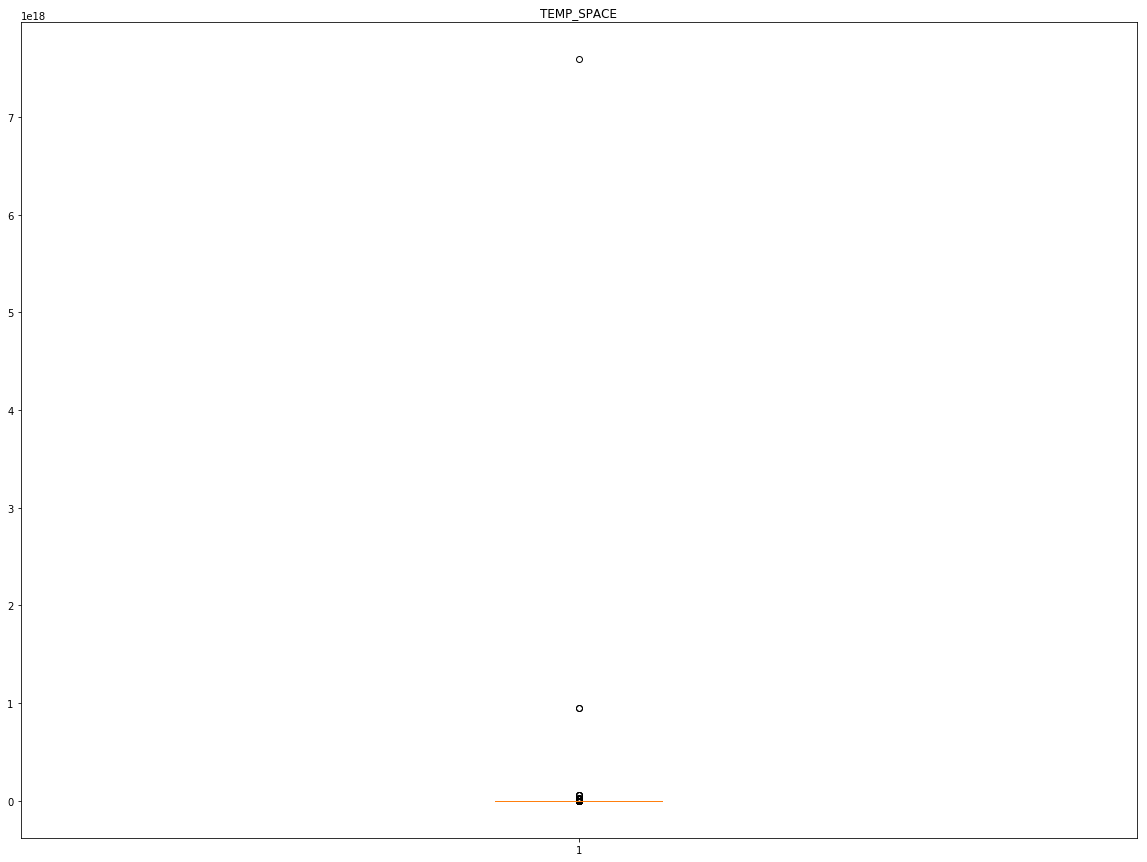

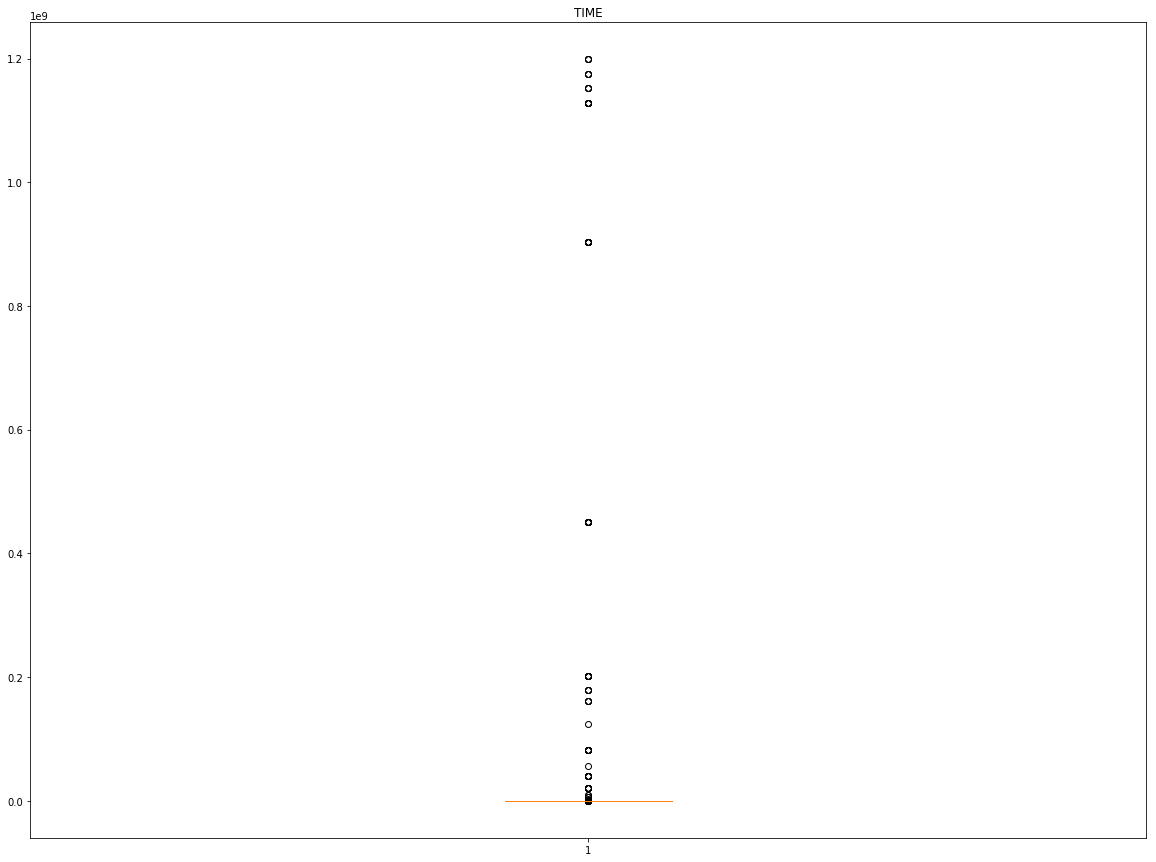

In [337]:
plt.rcParams['figure.figsize'] = [20, 15]
plt.boxplot(rep_vsql_plan_df['COST'].values)
plt.title('COST')
plt.show()
plt.boxplot(rep_vsql_plan_df['CARDINALITY'].values)
plt.title('CARDINALITY')
plt.show()
plt.boxplot(rep_vsql_plan_df['BYTES'].values)
plt.title('BYTES')
plt.show()
plt.boxplot(rep_vsql_plan_df['IO_COST'].values)
plt.title('IO_COST')
plt.show()
plt.boxplot(rep_vsql_plan_df['TEMP_SPACE'].values)
plt.title('TEMP_SPACE')
plt.show()
plt.boxplot(rep_vsql_plan_df['TIME'].values)
plt.title('TIME')
plt.show()

### K-Means Clustering (K=2)

Attempts at clustering data (Separation between inliers and outliers). Initial attempts will target K=2, and then visualize centroid to gauge their effectiveness in the achieved clustering.

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)
[1 1 1 ... 1 1 1]
Unique: [0 1]
Counts: [  18945 1309697]
[[ 2.40158879e+05  1.68439355e+06  1.87122424e+04  3.03824802e+01
   3.29926834e+03  5.50490765e+00  4.06048923e+03  6.97810026e+00
   3.29934037e+03  5.49936675e+00 -5.27506927e-11  1.82165394e-12
   3.21519367e+02  1.21725594e+00  9.37467018e-01  1.21372032e-03
   3.29973879e+03  5.49324538e+00  3.08056035e+08  5.43990400e+05
   8.15366363e+08  1.46280024e+06  2.18103255e+05  3.48909340e+02
   1.31115235e+10  2.42640594e+07  1.33151428e+10  2.46490333e+07
   6.84212006e+08  1.22048045e+06  1.64349067e+06  3.19454443e+03
   3.14642960e+05  5.46939947e+02  7.80719456e+06  1.28989110e+04
   4.01213765e-06  1.15232979e-09  2.58734551e+12  7.59576351e+08
   3.31453568e+07  1.49603593e+04  2.52297019e+12  7.50104718e+08
   6.29404523e+04  9.67815303e+00  

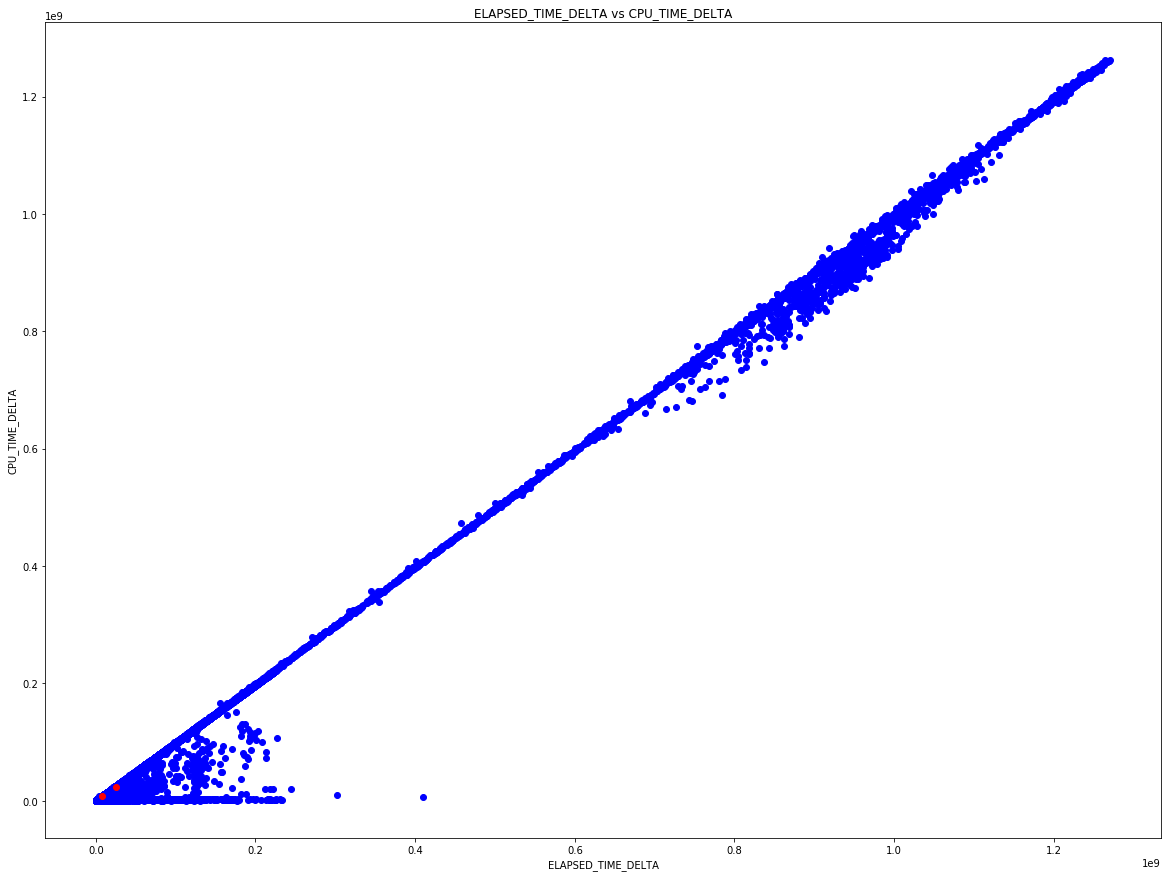

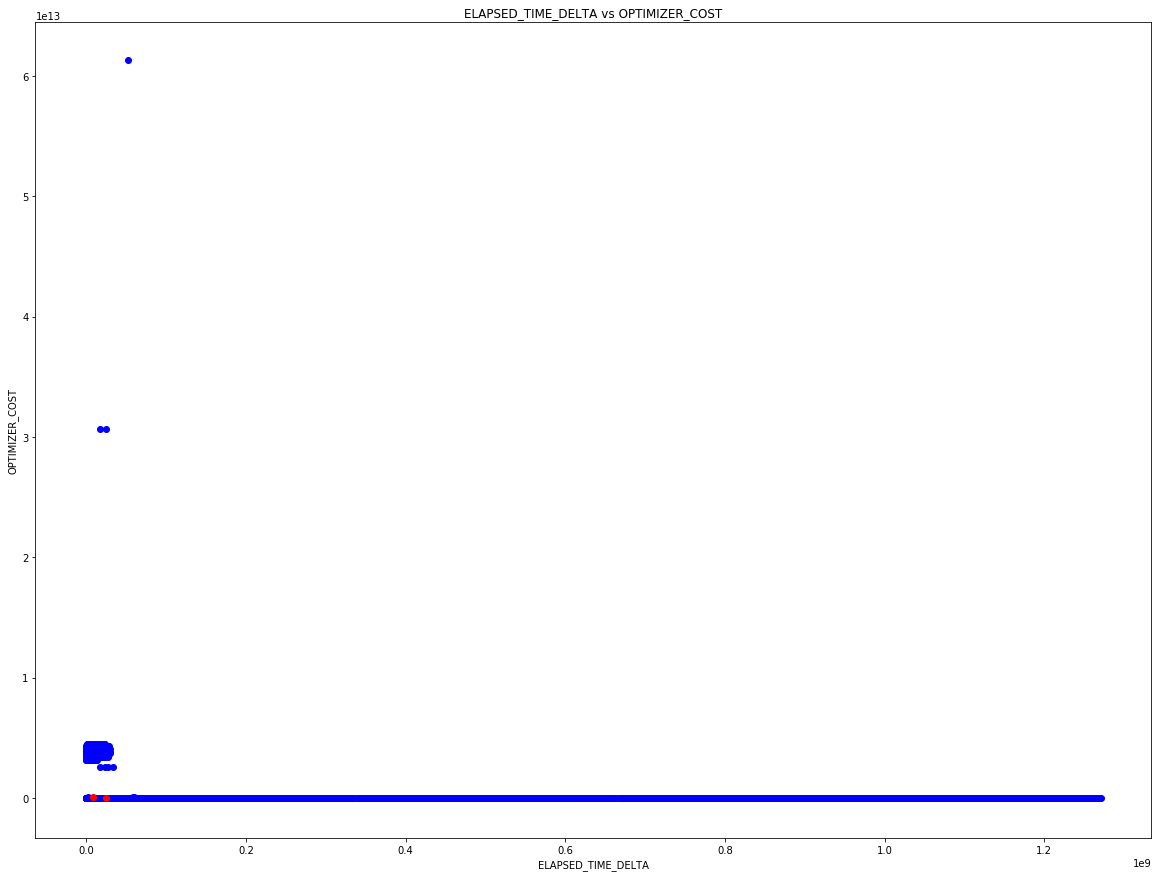

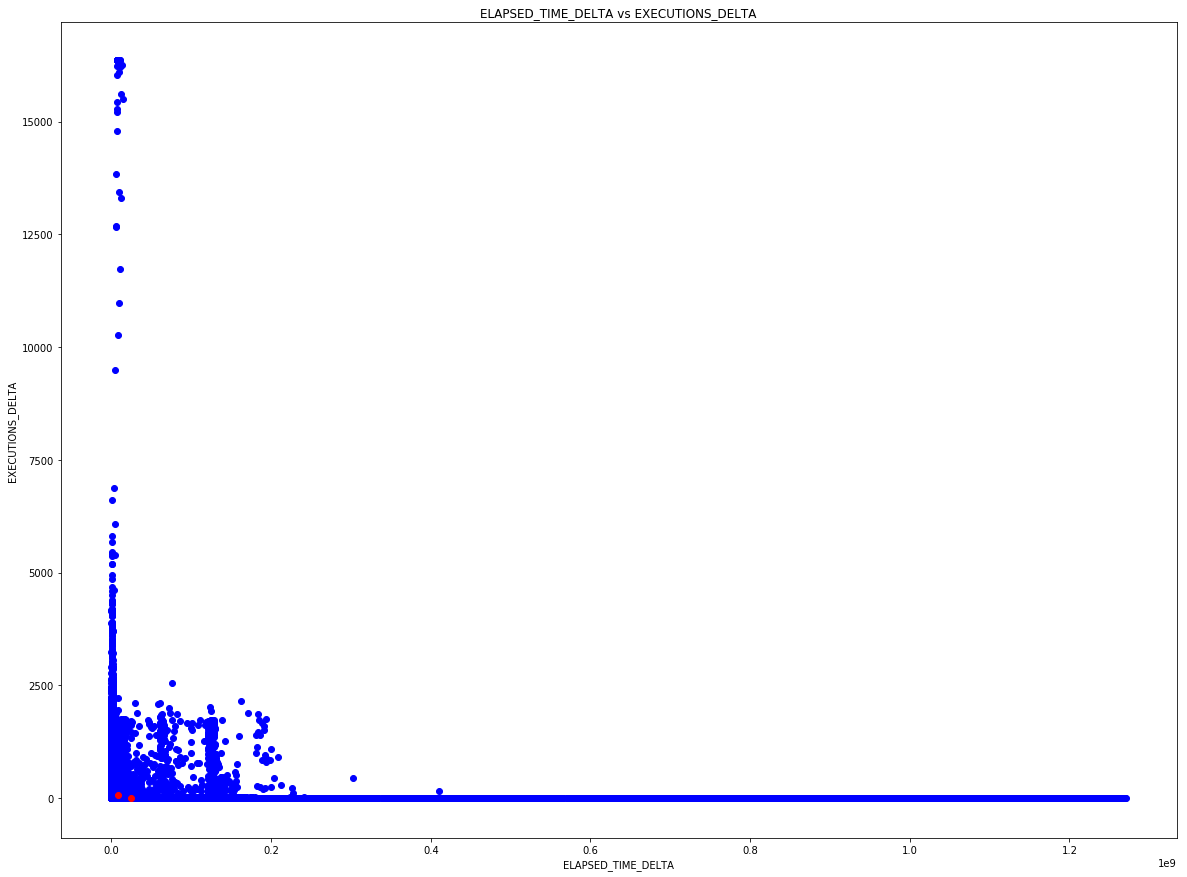

In [338]:
def get_col_pos(df, target_label):
    """
    Iterates over column, and retrieves position of col in dataset
    """
    columns = df.columns
    index = -1
    for i in range(0,len(columns)):
        if columns[i].lower() == target_label.lower():
            index = i
            break
    return index
#
K = 2
kmeans_hist = KMeans(n_clusters=K, random_state=0).fit(rep_hist_snapshot_df.values)
print(kmeans_hist)
print(kmeans_hist.labels_)
unique, counts = np.unique(kmeans_hist.labels_, return_counts=True)
print('Unique: ' + str(unique))
print('Counts: ' + str(counts))
print(kmeans_hist.cluster_centers_)
#
plt.rcParams['figure.figsize'] = [20, 15]
##################################
plt.scatter(x=rep_hist_snapshot_df.values[:,get_col_pos(rep_hist_snapshot_df, 'ELAPSED_TIME_DELTA')],
            y=rep_hist_snapshot_df.values[:,get_col_pos(rep_hist_snapshot_df, 'CPU_TIME_DELTA')],
            c='b')
plt.scatter(x=kmeans_hist.cluster_centers_[:,get_col_pos(rep_hist_snapshot_df, 'ELAPSED_TIME_DELTA')],
            y=kmeans_hist.cluster_centers_[:,get_col_pos(rep_hist_snapshot_df, 'CPU_TIME_DELTA')],
            c='r')
plt.title('ELAPSED_TIME_DELTA vs CPU_TIME_DELTA')
plt.xlabel('ELAPSED_TIME_DELTA')
plt.ylabel('CPU_TIME_DELTA')
plt.show()
##################################
plt.scatter(x=rep_hist_snapshot_df.values[:,get_col_pos(rep_hist_snapshot_df, 'ELAPSED_TIME_DELTA')],
            y=rep_hist_snapshot_df.values[:,get_col_pos(rep_hist_snapshot_df, 'OPTIMIZER_COST')],
            c='b')
plt.scatter(x=kmeans_hist.cluster_centers_[:,get_col_pos(rep_hist_snapshot_df, 'ELAPSED_TIME_DELTA')],
            y=kmeans_hist.cluster_centers_[:,get_col_pos(rep_hist_snapshot_df, 'OPTIMIZER_COST')],
            c='r')
plt.title('ELAPSED_TIME_DELTA vs OPTIMIZER_COST')
plt.xlabel('ELAPSED_TIME_DELTA')
plt.ylabel('OPTIMIZER_COST')
plt.show()
##################################
plt.scatter(x=rep_hist_snapshot_df.values[:,get_col_pos(rep_hist_snapshot_df, 'ELAPSED_TIME_DELTA')],
            y=rep_hist_snapshot_df.values[:,get_col_pos(rep_hist_snapshot_df, 'EXECUTIONS_DELTA')],
            c='b')
plt.scatter(x=kmeans_hist.cluster_centers_[:,get_col_pos(rep_hist_snapshot_df, 'ELAPSED_TIME_DELTA')],
            y=kmeans_hist.cluster_centers_[:,get_col_pos(rep_hist_snapshot_df, 'EXECUTIONS_DELTA')],
            c='r')
plt.title('ELAPSED_TIME_DELTA vs EXECUTIONS_DELTA')
plt.xlabel('ELAPSED_TIME_DELTA')
plt.ylabel('EXECUTIONS_DELTA')
plt.show()

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)
[0 0 0 ... 0 0 0]
Unique: [0 1]
Counts: [31146    14]
[[3.88461761e+01 4.38032802e+09 3.37677281e+10 1.05859403e+13
  2.34849771e+14 9.58678482e-01 2.81085220e+10 7.61621799e+13
  1.14794815e+06]
 [2.92857143e+00 1.71428490e+00 2.61162121e+13 1.67377742e+17
  7.43320074e+18 2.22044605e-16 2.17397640e+13 5.42222266e+17
  1.02016454e+09]]


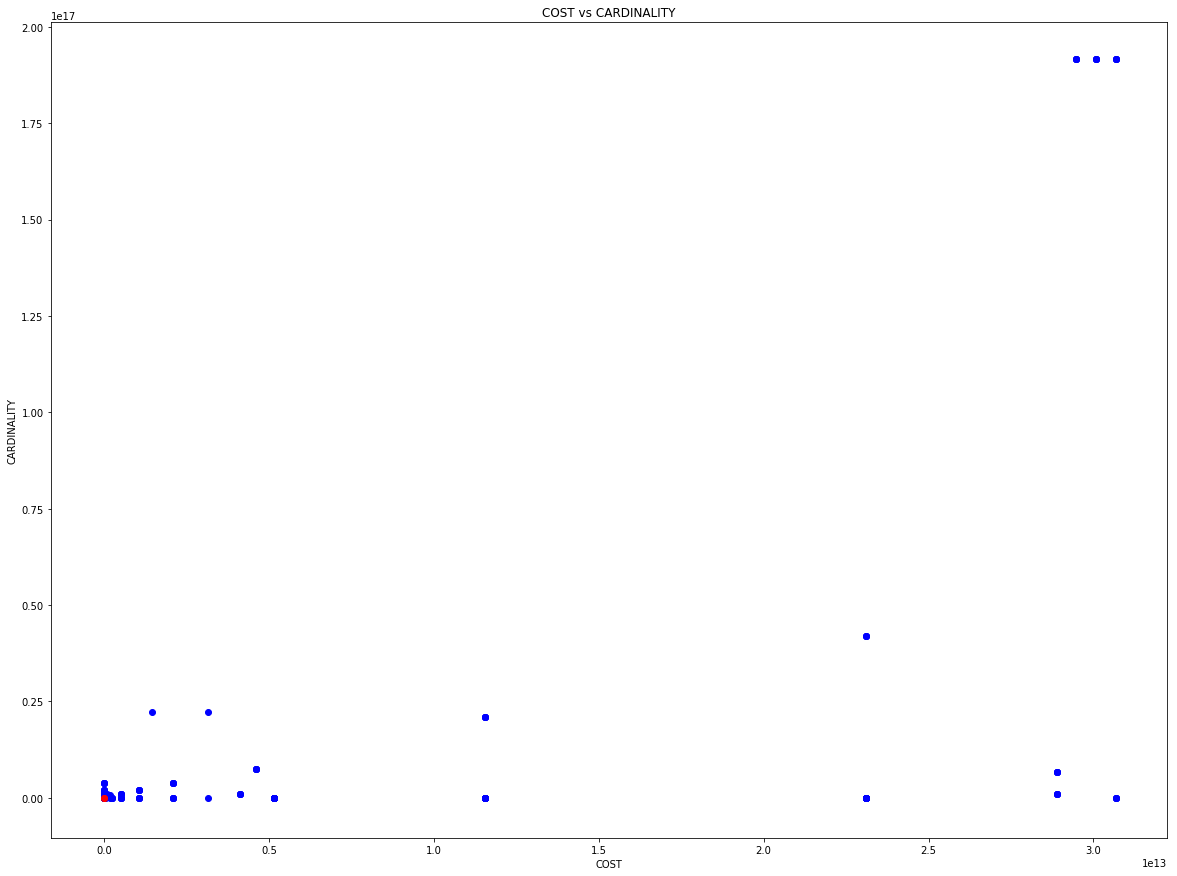

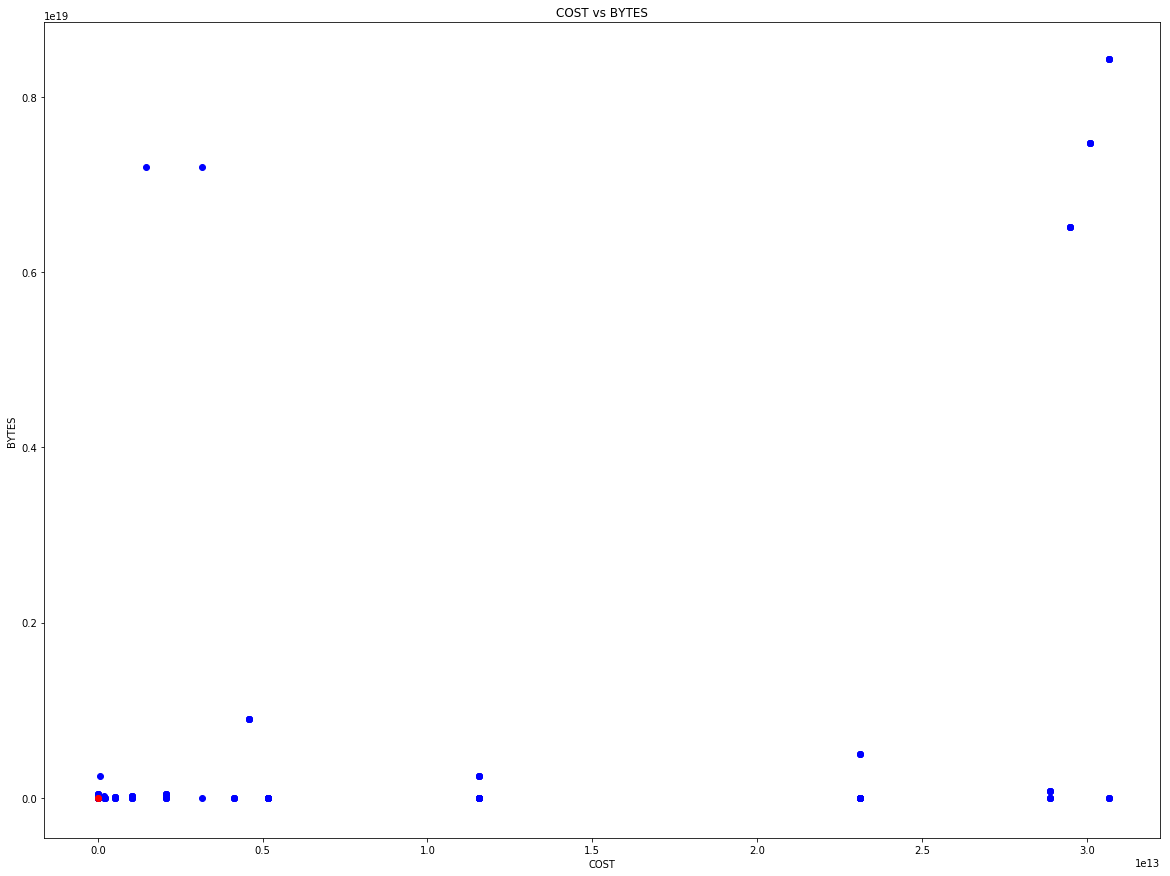

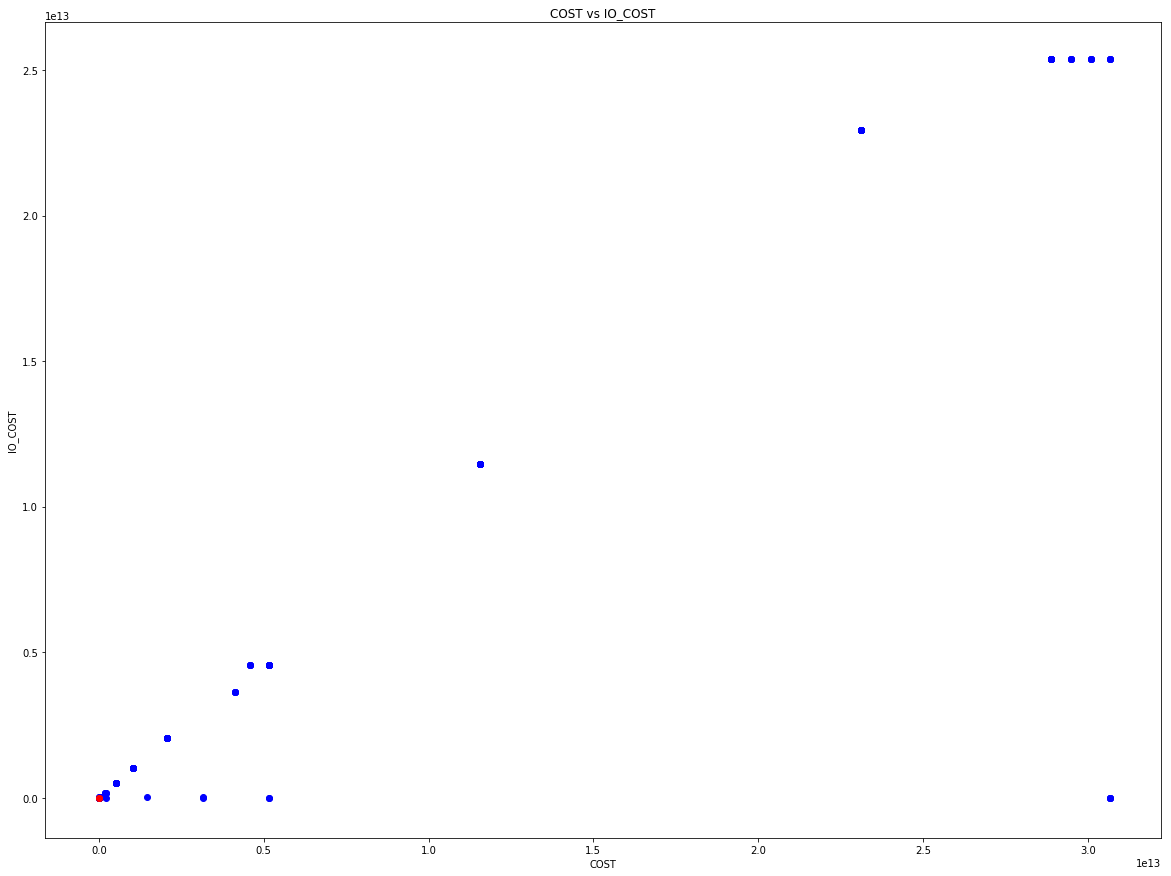

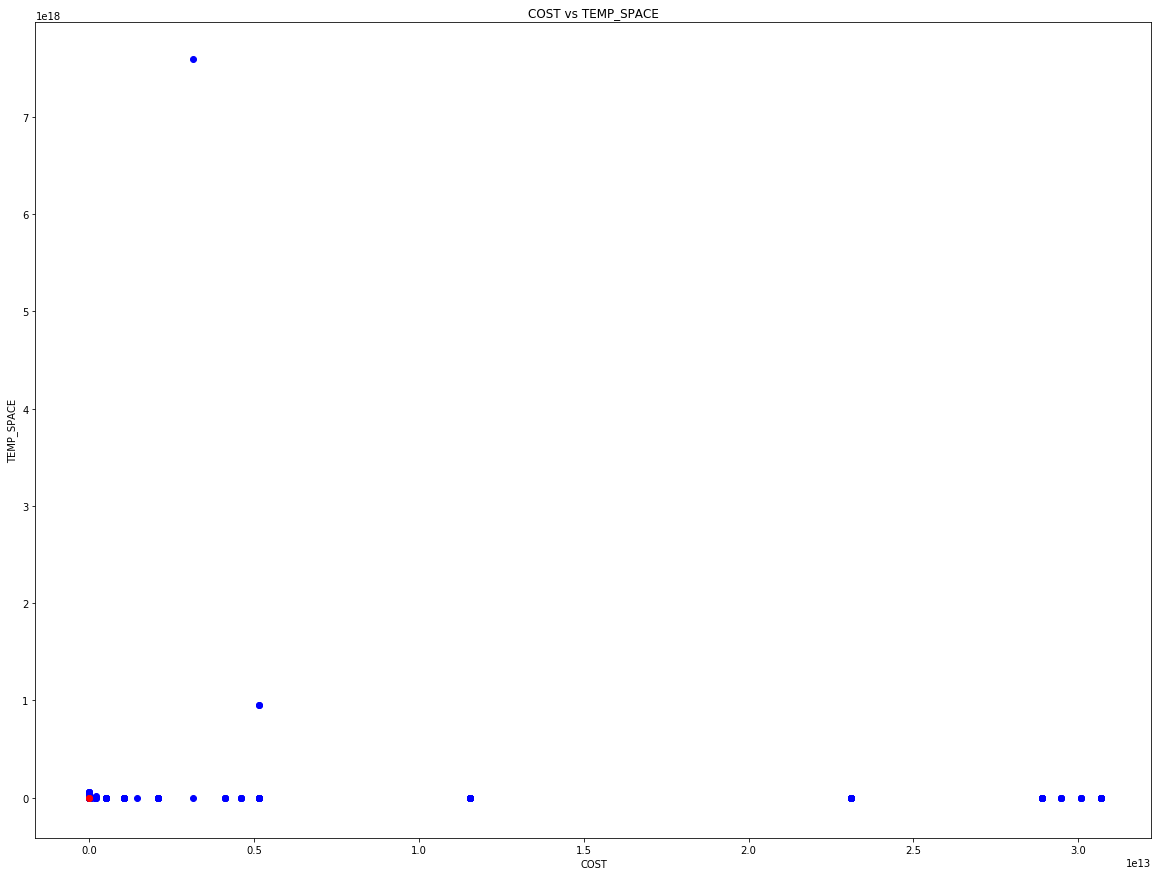

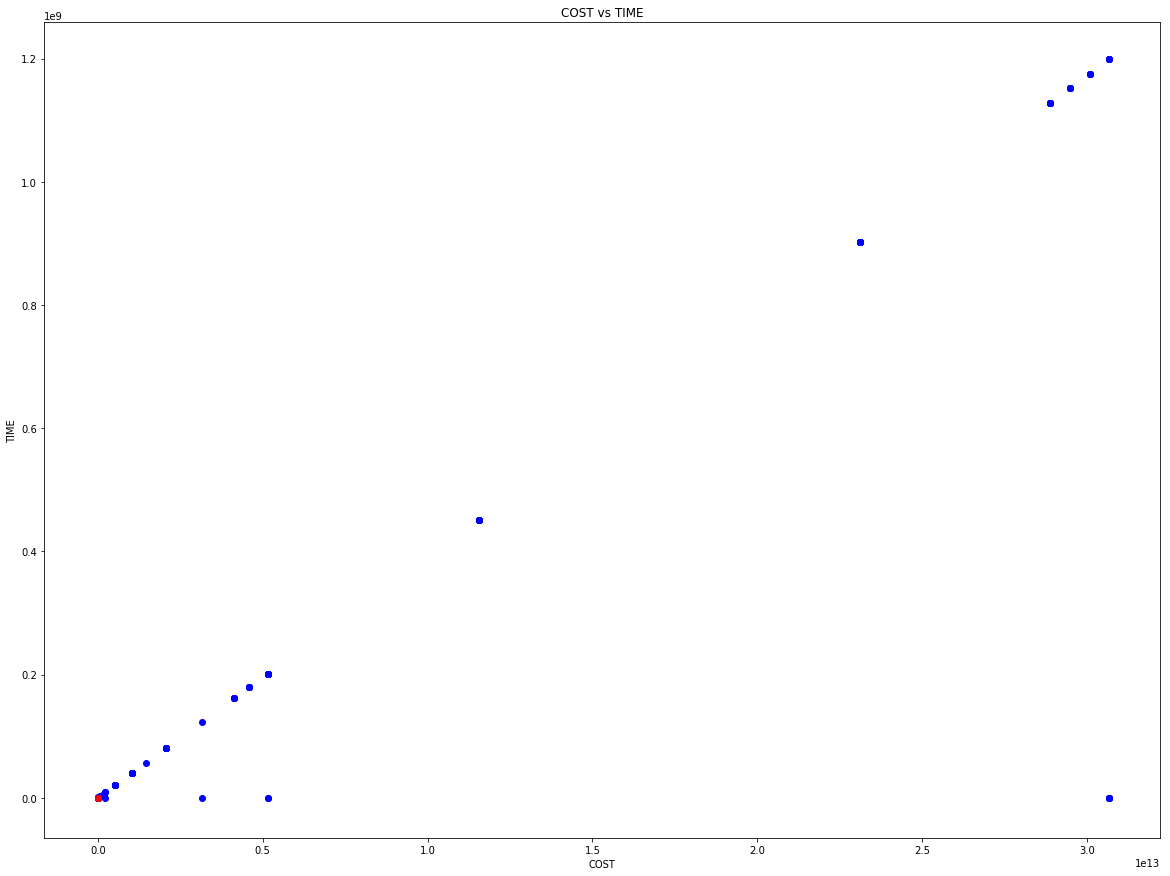

In [339]:
#
kmeans_vsql = KMeans(n_clusters=K, random_state=0).fit(rep_vsql_plan_df.values)
print(kmeans_vsql)
print(kmeans_vsql.labels_)
unique, counts = np.unique(kmeans_vsql.labels_, return_counts=True)
print('Unique: ' + str(unique))
print('Counts: ' + str(counts))
print(kmeans_vsql.cluster_centers_)
#
plt.rcParams['figure.figsize'] = [20, 15]
##################################
plt.scatter(x=rep_vsql_plan_df.values[:,get_col_pos(rep_vsql_plan_df, 'COST')],
            y=rep_vsql_plan_df.values[:,get_col_pos(rep_vsql_plan_df, 'CARDINALITY')],
            c='b')
plt.scatter(x=kmeans_hist.cluster_centers_[:,get_col_pos(rep_vsql_plan_df, 'COST')],
            y=kmeans_hist.cluster_centers_[:,get_col_pos(rep_vsql_plan_df, 'CARDINALITY')],
            c='r')
plt.title('COST vs CARDINALITY')
plt.xlabel('COST')
plt.ylabel('CARDINALITY')
plt.show()
##################################
plt.scatter(x=rep_vsql_plan_df.values[:,get_col_pos(rep_vsql_plan_df, 'COST')],
            y=rep_vsql_plan_df.values[:,get_col_pos(rep_vsql_plan_df, 'BYTES')],
            c='b')
plt.scatter(x=kmeans_hist.cluster_centers_[:,get_col_pos(rep_vsql_plan_df, 'COST')],
            y=kmeans_hist.cluster_centers_[:,get_col_pos(rep_vsql_plan_df, 'BYTES')],
            c='r',)
plt.title('COST vs BYTES')
plt.xlabel('COST')
plt.ylabel('BYTES')
plt.show()
##################################
plt.scatter(x=rep_vsql_plan_df.values[:,get_col_pos(rep_vsql_plan_df, 'COST')],
            y=rep_vsql_plan_df.values[:,get_col_pos(rep_vsql_plan_df, 'IO_COST')],
            c='b')
plt.scatter(x=kmeans_hist.cluster_centers_[:,get_col_pos(rep_vsql_plan_df, 'COST')],
            y=kmeans_hist.cluster_centers_[:,get_col_pos(rep_vsql_plan_df, 'IO_COST')],
            c='r')
plt.title('COST vs IO_COST')
plt.xlabel('COST')
plt.ylabel('IO_COST')
plt.show()
##################################
plt.scatter(x=rep_vsql_plan_df.values[:,get_col_pos(rep_vsql_plan_df, 'COST')],
            y=rep_vsql_plan_df.values[:,get_col_pos(rep_vsql_plan_df, 'TEMP_SPACE')],
            c='b')
plt.scatter(x=kmeans_hist.cluster_centers_[:,get_col_pos(rep_vsql_plan_df, 'COST')],
            y=kmeans_hist.cluster_centers_[:,get_col_pos(rep_vsql_plan_df, 'TEMP_SPACE')],
            c='r')
plt.title('COST vs TEMP_SPACE')
plt.xlabel('COST')
plt.ylabel('TEMP_SPACE')
plt.show()
##################################
plt.scatter(x=rep_vsql_plan_df.values[:,get_col_pos(rep_vsql_plan_df, 'COST')],
            y=rep_vsql_plan_df.values[:,get_col_pos(rep_vsql_plan_df, 'TIME')],
            c='b')
plt.scatter(x=kmeans_hist.cluster_centers_[:,get_col_pos(rep_vsql_plan_df, 'COST')],
            y=kmeans_hist.cluster_centers_[:,get_col_pos(rep_vsql_plan_df, 'TIME')],
            c='r')
plt.title('COST vs TIME')
plt.xlabel('COST')
plt.ylabel('TIME')
plt.show()

In [340]:
for i in range(len(kmeans_hist.labels_)):
    if kmeans_hist.labels_[i] == 0:
        print(rep_hist_snapshot_df.iloc[i])
        break
print('----------------------------------------')
for i in range(len(kmeans_hist.labels_)):
    if kmeans_hist.labels_[i] == 1:
        print(rep_hist_snapshot_df.iloc[i])
        break
print('----------------------------------------')
print('----------------------------------------')
print('----------------------------------------')
for i in range(len(kmeans_vsql.labels_)):
    if kmeans_vsql.labels_[i] == 0:
        print(rep_vsql_plan_df.iloc[i])
        break
print('----------------------------------------')
for i in range(len(kmeans_vsql.labels_)):
    if kmeans_vsql.labels_[i] == 1:
        print(rep_vsql_plan_df.iloc[i])
        break

OPTIMIZER_COST                   6.662160e+05
SHARABLE_MEM                     6.757687e+06
FETCHES_TOTAL                    4.018000e+03
FETCHES_DELTA                    1.000000e+01
END_OF_FETCH_COUNT_TOTAL         2.009000e+03
END_OF_FETCH_COUNT_DELTA         5.000000e+00
SORTS_TOTAL                      2.009000e+03
SORTS_DELTA                      5.000000e+00
EXECUTIONS_TOTAL                 2.009000e+03
EXECUTIONS_DELTA                 5.000000e+00
PX_SERVERS_EXECS_TOTAL           0.000000e+00
PX_SERVERS_EXECS_DELTA           0.000000e+00
LOADS_TOTAL                      1.320000e+02
LOADS_DELTA                      0.000000e+00
INVALIDATIONS_TOTAL              0.000000e+00
INVALIDATIONS_DELTA              0.000000e+00
PARSE_CALLS_TOTAL                2.009000e+03
PARSE_CALLS_DELTA                5.000000e+00
DISK_READS_TOTAL                 1.516517e+08
DISK_READS_DELTA                 3.929770e+05
BUFFER_GETS_TOTAL                3.146647e+08
BUFFER_GETS_DELTA                7

### Clustering Validation

So as to verify the success of the clustering attempts, the achieved clustering labels require to be compared
to what is assumed to be the actual label predictions. These 'actual' clusters will be assumed to coincide with
the data matrix average - if a particular data vector is larger/smaller than the mean threshold, it will coincide in one cluster or the other.

In [376]:
class ValidateKMeans:
    """
    Wrapper class for the KMeans algorithm, so as to validate the clustering it has achieved
    """
    #
    def __init__(self, X, k):
        self.X = X
        self.k = k
        self.model = KMeans(n_clusters=self.k, random_state=0, init='k-means++',n_jobs=2)
        self.model.fit(self.X)
        self.__y_labels = self.model.labels_
    #        
    def __get_threshold_vector(self):
        mean = np.mean(self.X.values)
        std = np.std(self.X.values)
        std3 = np.multiply(std, 3)
        return np.add(mean, std3)
    #
    def __calculate_expected_labels(self):
        """
        Estimates label clustering by comparing them to a threshold mean value. These labels
        will be used to gauge a scoring for the unsupervised clustering achieved by the K-Means algorithm.
        """
        mean_vect = self.__get_threshold_vector()
        mean_labels = []
        for vector in self.X.values:
            if np.greater(vector, mean_vect).any():
                mean_labels.append(1)
            else:
                mean_labels.append(0)
        return mean_labels
    #
    def label_centroids(self):
        centroids = self.model.cluster_centers_
        mean_vect = self.__get_threshold_vector()
        categorized_labels = [] # [[Self_Classified_Label,Centroid_Label],[Self_Classified_Label,Centroid_Label],...]
        for i in range(len(centroids)):
            if np.greater(centroids[i], mean_vect).any():
                categorized_labels.append([1,i])
            else:
                categorized_labels.append([0,i])
        return categorized_labels
    #
    def evaluate_clusters(self):
        y = self.__calculate_expected_labels()
        yhat = []
        labelled_centroids = self.label_centroids()
        print('Labeled Centroids: ' + str(labelled_centroids))
        #
        for label in self.__y_labels:
            for x, i in labelled_centroids:
                if label == i:
                    yhat.append(x)
                    break
        #
        print('Total Clusters [' + str(self.k) + ']\nDistribution:')
        unique, counts = np.unique(y, return_counts=True)
        print('Expected Label Distribution')
        for i in range(len(unique)):
            print('Label [' + str(unique[i]) + '] -> Count [' + str(counts[i]) + ']')
        unique, counts = np.unique(yhat, return_counts=True)
        print('Clustered Label Distribution')
        for i in range(len(unique)):
            print('Label [' + str(unique[i]) + '] -> Count [' + str(counts[i]) + ']')
        #
        print("\n----\nAccuracy: " + str(accuracy_score(y, yhat)))
        print("Precision: " + str(precision_score(y, yhat, average='micro')))
        print("Recall: " + str(recall_score(y, yhat, average='micro')))
        print("F-Score: " + str(f1_score(y, yhat, average='micro')) + "\n----")

### Exhausting K

Iterating over a number of K values, whilst gauging K under different number of combinations. Each K denotes the number of clusters as to group the data with. In turn, each cluster is then further categorized into 2 groups, those pertaining to:
* Inliers
* Outliers

In [ ]:
def exhaust_k_possibilities(df):
    """
    Method which attempts to exhaust a number of K options for the input pandas dataframe.
    K Attempts will be attempted in steps of 2, so as to speed up the K finding process.

    :param - df (Dataframe of type Pandas)
    """
    for k in range(2, len(df.columns), 2):
        print('Iteration -------------[' + str(k) + ']-------------')
        validInstance = ValidateKMeans(df, k)
        print(validInstance.model)
        validInstance.evaluate_clusters()
#
exhaust_k_possibilities(df=rep_hist_snapshot_df)
exhaust_k_possibilities(df=rep_vsql_plan_df)

Iteration -------------[2]-------------
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=2, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)
Labeled Centroids: [[0, 0], [1, 1]]
Total Clusters [2]
Distribution:
Expected Label Distribution
Label [0] -> Count [1213750]
Label [1] -> Count [114892]
Clustered Label Distribution
Label [0] -> Count [1309697]
Label [1] -> Count [18945]

----
Accuracy: 0.9277856638582854
Precision: 0.9277856638582854
Recall: 0.9277856638582854
F-Score: 0.9277856638582854
----
Iteration -------------[4]-------------
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=2, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)
Labeled Centroids: [[0, 0], [1, 1], [1, 2], [1, 3]]
Total Clusters [4]
Distribution:
Expected Label Distribution
Label [0] -> Count [1213750]
Label [1] -> Count [114892]
Clustered Label Distribu

### Isolation Forest Outlier Detection

This section moves past K-Means clustering prediction, and attempts to detect / flag outliers using the Isolation Forest ensemble algorithm.

Return the anomaly score of each sample using the IsolationForest algorithm

The IsolationForest ‘isolates’ observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature.

Since recursive partitioning can be represented by a tree structure, the number of splittings required to isolate a sample is equivalent to the path length from the root node to the terminating node.

This path length, averaged over a forest of such random trees, is a measure of normality and our decision function.

Random partitioning produces noticeably shorter paths for anomalies. Hence, when a forest of random trees collectively produce shorter path lengths for particular samples, they are highly likely to be anomalies.

In [ ]:
#
# REP_HIST_SNAPSHOT
iforest_rep_hist_snapshot = IsolationForest(n_estimators=100, max_samples=256, contamination=0.2, random_state=0)
iforest_rep_hist_snapshot.fit(rep_hist_snapshot_df.values)
print(iforest_rep_hist_snapshot)
scores = iforest_rep_hist_snapshot.decision_function(rep_hist_snapshot_df.values)
plt.figure(figsize=(12, 8))
plt.hist(scores, bins=50);
plt.title('Isolation Forest Scorings')
plt.show()

In [ ]:
#
# REP_VSQL_PLAN
iforest_rep_vsql_plan = IsolationForest(n_estimators=100, max_samples=256, contamination=0.2, random_state=0)
iforest_rep_vsql_plan.fit(rep_vsql_plan_df.values)
print(iforest_rep_vsql_plan)
scores = iforest_rep_vsql_plan.decision_function(rep_vsql_plan_df.values)
plt.figure(figsize=(12, 8))
plt.hist(scores, bins=50);
plt.title('Isolation Forest Scorings')
plt.show()